# Code for the figures
This notebook contains scripts for producing figures in the paper and SI.

## Import required libraries 

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import string
import random

import mplot as mp

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

import seaborn as sns

from timeit import default_timer as timer

%matplotlib inline

## Global variables for plotting

In [3]:
DATA_FOLDER = 'data/'
FRESH_RUN = False

# paper style
FONTFAMILY   = 'Arial' #'Avenir'
SIZESUBLABEL = 8
SIZELABEL    = 6
SIZETICK     = 6
SMALLSIZEDOT = 6.

SIZELINE = 1.0
AXWIDTH = 0.4
SUBLABEL_SIZE = 10
LABEL_SIZE = 6
FAMILY = 'Arial'
SINGLE_COLUMN = 8.5/2.54
ONE_FIVE_COLUMN = 11.4/2.54
DOUBLE_COLUMN = 17.4/2.54
SLIDE_WIDTH = 10.5

mpl.rc('lines', linewidth=SIZELINE)
mpl.rc('axes', linewidth=AXWIDTH)
mpl.rc('font', size=LABEL_SIZE, family=FAMILY)
mpl.rc(('xtick.major', 'xtick.minor', 'ytick.major', 'ytick.minor'), width=AXWIDTH)

TRUE_MEAN_LABEL = 'True mean, $\mu_t$'
ESTD_MEAN_LABEL = 'Estimated\nmean, $\hat{\mu}$'
TRUE_STD_LABEL = 'True standard\ndeviation, $\sigma_t$'
ESTD_STD_LABEL = 'Estimated standard\ndeviation, $\hat{\sigma}$'
ENCOUNTER_LABEL = 'Target cell encounters'
POA_LABEL = 'Probability of activation'

DASH_STYLE = dict(color='k', linestyle='dashed', alpha=0.5)

BKCOLOR        = '#252525'
LCOLOR         = '#969696'
COLOR_ONE      = '#3E8DCF'
COLOR_TWO      = '#FFB511'
COLOR_THREE    = '#EB4025'
COLOR_THREE_LT = '#F08F78'

FIGPROPS = {
    'transparent' : True,
    #'bbox_inches' : 'tight'
}

DEF_LABELPROPS = {
    'family' : FONTFAMILY,
    'size'   : SIZELABEL,
    'color'  : BKCOLOR
}

DEF_LINEPROPS = {
    'lw'        : SIZELINE,
    'ls'        : '-',
}

DEF_ERRORPROPS = {
    'mew'        : 0,
    'markersize' : SMALLSIZEDOT/2,
    'fmt'        : 'o',
    'elinewidth' : SIZELINE/2,
    'capthick'   : 0,
    'capsize'    : 0,
}

DEF_SCATTERPROPS = {
    'lw'        : 0,
    's'         : SMALLSIZEDOT,
    'marker'    : 'o'
}

## Frequently used functions

In [4]:
# update the mean and std
def UPDATE(initial_mean, initial_std, alpha, kappa, num_encounter, m_env, var_env):
    # constants in equtions for variance updating
    varc1 = (alpha-1)/(alpha-0.5)
    varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
    mean = [0]*num_encounter
    std = [0]*num_encounter
    mean[0] = initial_mean
    std[0] = initial_std
    # update mean and std for num_encounter steps
    for nstep in range(1, num_encounter):
        x = random.gauss(m_env, np.sqrt(var_env))  # gauss(mean, std)
        mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
        std[nstep] = np.sqrt(varc1*std[nstep-1]**2 +
                             varc2*(x-mean[nstep-1])**2)
    return(mean, std)


# Calculate the probability of activation
def POA(alpha, kappa, m, beta, u_target, var_target):
    theta = 0.01
    threshold = sp.stats.t.ppf(1-theta, 2*alpha, m,
                               np.sqrt((kappa+1)*beta/kappa/alpha))
    poa = 1-sp.stats.norm.cdf(threshold, loc=u_target,
                              scale=np.sqrt(var_target))
    return(poa)


# use modified signal to update the mean and variance
def UPDATE_ALT(initial_mean, initial_std, alpha, kappa, num_encounter, m_env, var_env):
    # constants in equtions for variance updating
    varc1 = (alpha-1)/(alpha-0.5)
    varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
    mean = [0]*num_encounter
    std = [0]*num_encounter
    mean[0] = initial_mean
    std[0] = initial_std
    for nstep in range(1, num_encounter):
        x = random.gauss(m_env, np.sqrt(var_env))  # gauss(mean,std)
        x = mean[nstep-1]+(2/(1 + np.exp(-(x - mean[nstep-1]))) - 1)*2
        mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
        std[nstep] = np.sqrt(varc1*std[nstep-1]**2 +
                             varc2*(x-mean[nstep-1])**2)
    return(mean, std)


# numerically calculate the transformed std when signal is modified by x^{'} = m+r*(2/(1+e^{-x})-1),
# x~N(mu,sigma^2) y=x^{'}-m y~(-r,r) assuming m=mu when it converges.
def TRANSFORMED_STD(r, sigma):
    firstmom = sp.integrate.quad(lambda y: y*2*r/(np.sqrt(2*np.pi)*sigma*(r**2-y**2)) 
                                 * np.exp(-(np.log((r+y)/(r-y)))**2/(2*sigma**2)), -2, 2)[0]
    secondmom = sp.integrate.quad(lambda y: y**2*2*r/(np.sqrt(2*np.pi)*sigma*(r**2-y**2))
                                  * np.exp(-(np.log((r+y)/(r-y)))**2/(2*sigma**2)), -2, 2)[0]
    return(np.sqrt(secondmom-firstmom**2))

# Figure 1. Overview figure

In [4]:
figw = SINGLE_COLUMN/2
figh = figw * 0.5
xmin = -2
xmax = 6
ymin = 0
ymax = 0.42

# Plotting -----------------------------------------------

fig = plt.figure(figsize=(figw, figh))

ax = fig.add_axes([0.10, 0.10, 0.80, 0.80])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xticks([])
ax.set_yticks([])

c_prior = '#969696'
mu_prior = 1
sigma_prior = 1
x_prior = np.arange(xmin, xmax, 0.01)
y_prior = np.exp(-(x_prior - mu_prior)**2 / (2 * sigma_prior**2)
                 ) / (sigma_prior * np.sqrt(2*np.pi))

ax.plot(x_prior, y_prior, c=c_prior)
ax.fill_between(x_prior, y_prior, color=c_prior, alpha=0.2, lw=0)

c_post = '#FFB511'
mu_post = 1.1
sigma_post = 1
x_post = np.arange(xmin, xmax, 0.01)
y_post = np.exp(-(x_post - mu_post)**2 / (2 * sigma_post**2)) / \
    (sigma_post * np.sqrt(2*np.pi))

ax.plot(x_post, y_post, c=c_post)
ax.fill_between(x_post, y_post, color=c_post, alpha=0.2, lw=0)

ax.axvline(1.5, color='k')

plt.savefig('figures/fig1-normal.pdf', format='pdf', dpi=300, transparent=True)
plt.close()


# Plotting -----------------------------------------------

fig = plt.figure(figsize=(figw, figh))

ax = fig.add_axes([0.10, 0.10, 0.80, 0.80])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xticks([])
ax.set_yticks([])

c_prior = '#969696'
mu_prior = 1
sigma_prior = 1
x_prior = np.arange(xmin, xmax, 0.01)
y_prior = np.exp(-(x_prior - mu_prior)**2 / (2 * sigma_prior**2)
                 ) / (sigma_prior * np.sqrt(2*np.pi))

ax.plot(x_prior, y_prior, c=c_prior)
ax.fill_between(x_prior, y_prior, color=c_prior, alpha=0.2, lw=0)

c_post = '#FFB511'
mu_post = 1.8
sigma_post = 1.2
x_post = np.arange(xmin, xmax, 0.01)
y_post = np.exp(-(x_post - mu_post)**2 / (2 * sigma_post**2)) / \
    (sigma_post * np.sqrt(2*np.pi))

ax.plot(x_post, y_post, c=c_post)
ax.fill_between(x_post, y_post, color=c_post, alpha=0.2, lw=0)

ax.axvline(4.0, color='k')

plt.savefig('figures/fig1-aberrant.pdf', format='pdf', dpi=300, transparent=True)
plt.close()

# Figure 2. Immune cells adapt to a static environment

## Part 1. Generation of data for the evolution of mean and standard deviation

In [5]:
if FRESH_RUN:
    # Figure 2 data generation
    alphas = [5, 10, 20]
    kappas = [10, 20, 40]
    m_env = 0
    var_env = 4
    num_encounter = 200
    df = pd.DataFrame({'Initial mean': [],
                       'Initial std': [],
                       'True mean': [],
                       'True std': [],
                       'alpha': [],
                       'kappa': [],
                       'Encounters': [],
                       'Mean': [],
                       'Std': []
                       })
    datatype_dict = {'Initial mean': float,
                     'Initial std': float,
                     'True mean': float,
                     'True std': float,
                     'alpha': int,
                     'kappa': int,
                     'Encounters': int,
                     'Mean': float,
                     'Std': float
                     }
    df = df.astype(datatype_dict)

    for alpha, kappa in zip(alphas, kappas):
        # case 1. initial different mean and same var ------------------------------------
        initial_means = np.arange(-10, 11, 2)
        initial_std = 1
        num_means = len(initial_means)
        for i_case in range(num_means):
            initial_mean = initial_means[i_case]
            mean, std = UPDATE(initial_mean, initial_std, alpha,
                               kappa, num_encounter, m_env, var_env)
            num_rows = len(mean)
            df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
                                'Initial std': [initial_std]*num_rows,
                                'True mean': [m_env]*num_rows,
                                'True std': [np.sqrt(var_env)]*num_rows,
                                'alpha': [alpha]*num_rows,
                                'kappa': [kappa]*num_rows,
                                'Encounters': np.arange(num_rows),
                                'Mean': mean,
                                'Std': std
                                })
            df = pd.concat([df, df2])

        # case 2. initial same mean and different var ------------------------------------
        initial_mean = 0
        initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
        num_stds = len(initial_stds)
        for i_case in range(num_means, num_means+num_stds):
            initial_std = initial_stds[i_case-num_means]
            mean, std = UPDATE(initial_mean, initial_std, alpha,
                               kappa, num_encounter, m_env, var_env)
            num_rows = len(mean)
            df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
                                'Initial std': [initial_std]*num_rows,
                                'True mean': [m_env]*num_rows,
                                'True std': [np.sqrt(var_env)]*num_rows,
                                'alpha': [alpha]*num_rows,
                                'kappa': [kappa]*num_rows,
                                'Encounters': np.arange(num_rows),
                                'Mean': mean,
                                'Std': std
                                })
            df = pd.concat([df, df2])

        df.to_csv('%sestimated_mean_std.csv.gz' % DATA_FOLDER, index=None,
                  header=True, compression='gzip')

    print('Fig 2 data done')

## Part 2. Plotting

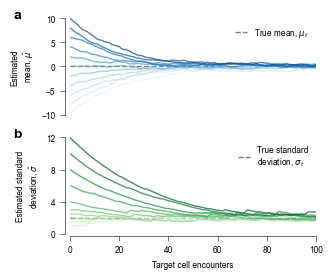

In [6]:
# Figure 2 plottting

alpha = 10
kappa = 20
m_env = 0
var_env = 4
num_encounter = 100

initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)

initial_mean = 0
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)

# read data
data = pd.read_csv('%sestimated_mean_std.csv.gz' %
                   DATA_FOLDER, compression='gzip')

# Plotting -----------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))

ax1 = fig.add_axes([0.20, 0.57, 0.735, 0.36])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.set_xlim([0, num_encounter])
ax1.set_ylim([-10, 10])
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_ylabel(ESTD_MEAN_LABEL, fontsize=LABEL_SIZE)
fig.text(0.03, 0.93, string.ascii_uppercase[0].lower(), size=SUBLABEL_SIZE, weight='bold')
ax1.axhline(0.0, label=TRUE_MEAN_LABEL, **DASH_STYLE)

ax2 = fig.add_axes([0.20, 0.125, 0.735, 0.36])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.set_xlim([0, num_encounter])
ax2.set_ylim([0, 12])
ax2.set_yticks([0, 4, 8, 12])
ax2.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
ax2.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
fig.text(0.03, 0.485, string.ascii_uppercase[1].lower(), size=SUBLABEL_SIZE, weight='bold')
ax2.axhline(np.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
ax1.legend(loc='upper right', frameon=False, handlelength=1.5)
ax2.legend(loc='upper right', frameon=False, handlelength=1.5)

# Case 1 different means and same variance ---------------
mu_c = sns.color_palette('Blues', n_colors=num_means)
for j_mu in range(num_means):
    mean = data.loc[(data['alpha'] == alpha) 
                    & (data['Initial mean'] == initial_means[j_mu]) 
                    & (data['Initial std'] == initial_std)]['Mean']
    encouner = range(len(mean))
    ax1.plot(encouner, mean, alpha=0.7, c=mu_c[j_mu])


# Case 2 initial same mu and different var ---------------
std_c = sns.color_palette('Greens', n_colors=num_stds)
for j_std in range(num_stds):
    std = data.loc[(data['alpha'] == alpha) 
                   & (data['Initial mean'] == initial_mean) 
                   & (data['Initial std'] == initial_stds[j_std])]['Std']
    encounter = range(len(std))
    ax2.plot(encounter, std, alpha=0.7, c=std_c[j_std])

plt.savefig('figures/fig2-adaptation-static.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

##  Generating data

In [7]:
if FRESH_RUN:
    # Figure 3/SI2 data generation
    # variables
    num_cell = 500
    alpha = 10
    kappa = 20
    m_env1 = 0 # mean and variance of environments
    var_env1 = 1
    m_env2 = 5  
    var_env2 = 4
    num1env = 50 # encounter numbers in environments
    num2env = 100
    num3env = 150
    total_num = num1env+num2env+num3env

    df = pd.DataFrame({'alpha': [],
                       'kappa': [],
                       'True mean': [],
                       'True std': [],
                       'Cell No': [],
                       'Encounters': [],
                       'Mean': [],
                       'Std': [],
                       'Beta': [],
                       'Poa': []
                       })
    datatype_dict = {'alpha': int,
                     'kappa': int,
                     'True mean': float,
                     'True std': float,
                     'Cell No': int,
                     'Encounters': int,
                     'Mean': float,
                     'Std': float,
                     'Beta': float,
                     'Poa': float
                     }
    df = df.astype(datatype_dict)

    # loop over num_cell
    for i_cell in range(num_cell):
        # healthy environment
        mean, std = UPDATE(m_env1, np.sqrt(var_env1), alpha,
                           kappa, num1env, m_env1, var_env1)
        # unhealthy environment
        a, b = UPDATE(mean[-1], std[-1], alpha, kappa, num2env, m_env2, var_env2)
        mean += a
        std += b
        # healthy environment
        a, b = UPDATE(mean[-1], std[-1], alpha, kappa, num3env, m_env1, var_env1)
        mean += a
        std += b
        # calculate beta and poa
        beta = [item**2*(alpha-1) for item in std]
        poa = [POA(alpha, kappa, item1, item2, m_env2, var_env2)
               for item1, item2 in zip(mean, beta)]

        # data saving ----------------------------------------------------
        df2 = pd.DataFrame({'alpha': [alpha]*total_num,
                            'kappa': [kappa]*total_num,
                            'True mean': [m_env1]*num1env+[m_env2]*num2env+[m_env1]*num3env,
                            'True std': [np.sqrt(var_env1)]*num1env
                                        + [np.sqrt(var_env2)]*num2env
                                        + [np.sqrt(var_env1)]*num3env,
                            'Cell No': [i_cell]*total_num,
                            'Encounters': np.arange(total_num),
                            'Mean': mean,
                            'Std': std,
                            'Beta': beta,
                            'Poa': poa
                            })
        df = pd.concat([df, df2])
    print(df.head())
    df.to_csv('%sMultiEnvs_MultiCells_mean_std_beta_poa.csv.gz' % DATA_FOLDER,
              index=None, header=True, compression='gzip')
    print('MultiEnvs_MultiCells_mean_std_beta_poa data done')

# Figure 3. Immune cells adapt to changing environments

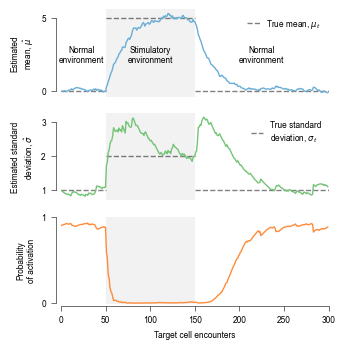

In [8]:
# Fig 3 plot

alpha = 10
kappa = 20
varc1 = (alpha-1)/(alpha-0.5) # constants frequently used
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1 = 0 # mean and variance of environments
var_env1 = 1
m_env2 = 5  
var_env2 = 4
num1env = 50 # encounter numbers
num2env = 100
num3env = 150
total_num = num1env+num2env+num3env

# load data
data = pd.read_csv('%sMultiEnvs_MultiCells_mean_std_beta_poa.csv.gz' %
                   (DATA_FOLDER), compression='gzip')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.0))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.165, 0.73, 0.8, 0.26])
ax2 = fig.add_axes([0.165, 0.42, 0.8, 0.26])
ax3 = fig.add_axes([0.165, 0.11, 0.8, 0.26])
ax1.tick_params(top=False, labelbottom=False)
ax2.tick_params(top=False, labelbottom=False)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax3.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))

ax1.set_xlim(0, total_num)
ax2.set_xlim(0, total_num)
ax3.set_xlim(0, total_num)
ax1.set_yticks([0, 5])
ax1.set_yticklabels([0, 5])
ax2.set_yticks([1, 2, 3])
ax2.set_yticklabels([1, 2, 3])
ax3.set_yticks([0, 1])

ax1.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)
ax2.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)
ax3.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)

ax1.hlines(y=m_env1, xmin=0, xmax=num1env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
ax1.hlines(y=m_env2, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax1.hlines(y=m_env1, xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)
ax2.hlines(y=np.sqrt(var_env1), xmin=0, xmax=num1env,
           label=TRUE_STD_LABEL, **DASH_STYLE)
ax2.hlines(y=np.sqrt(var_env2), xmin=num1env,
           xmax=num1env+num2env, **DASH_STYLE)
ax2.hlines(y=np.sqrt(var_env1), xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)

ax1.spines['left'].set_bounds(0, 5)
ax2.spines['left'].set_bounds(1, 3)
ax3.spines['left'].set_bounds(0, 1)

ax3.set_ylim(-0.01, 1)

mu_c = sns.color_palette('Blues', n_colors=1)
std_c = sns.color_palette('Greens', n_colors=1)
poa_c = sns.color_palette('Oranges', n_colors=1)
ax1.legend(loc='upper right', frameon=False, handlelength=1.5)
ax2.legend(loc='upper right', frameon=False, handlelength=1.5)
ax1.plot(data.loc[data['Cell No'] == 0]['Mean'], c=mu_c[0])
ax1.set_ylabel(ESTD_MEAN_LABEL)
ax2.plot(data.loc[data['Cell No'] == 0]['Std'], c=std_c[0])
ax2.set_ylabel(ESTD_STD_LABEL)
ax3.plot(data.loc[data['Cell No'] == 0]['Poa'], c=poa_c[0])
ax3.set_xlabel(ENCOUNTER_LABEL)
ax3.set_ylabel('Probability\nof activation')

ax1.text(23, 2.5, 'Normal\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)
ax1.text(100, 2.5, 'Stimulatory\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)
ax1.text(225, 2.5, 'Normal\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)

plt.savefig('figures/fig3-adaptation-dynamic.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Supplementary Figure 2. Steady state distribution of immune cell adaptation 

## Part 1. Solve the Fokker Planck Equation (See `FKE.py` which generates `Fokker_planck_solution.csv.gz`)

## Part 2. Calculate the probability of activation

In [9]:
if FRESH_RUN:
    # Fig 4 calculate poa at (m,\beta) points
    u2 = 2  # signal mean and std
    sigma2 = 1  
    theta = 0.01
    alpha = 10
    kappa = 20
    c1 = (alpha-1)/(alpha-0.5) # constant in betanew = c1*beta + c2*(x-mu)**2
    c2 = 0.5*(alpha-1)/(alpha-0.5)*kappa/(kappa+1)
    alpha = 10
    kappa = 20
    mean_antigen = 4.5  # antigen N(4.5,1) when calculating POA
    var_antigen = 1

    # grid
    NX = 101
    NY = 1001
    xmax = 2.5
    xmin = 1.5
    ymax = 15
    ymin = 5
    dx = (xmax-xmin)/(NX-1)
    dy = (ymax-ymin)/(NY-1)

    m = [0]*(NX*NY)
    beta = [0]*(NX*NY)
    poa = [0]*(NX*NY)
    for i in range(NX):
        for j in range(NY):
            m[i*NY+j] = xmin+i*dx
            beta[i*NY+j] = ymin+j*dy
            poa[i*NY+j] = POA(alpha, kappa, m[i*NY+j],
                              beta[i*NY+j], mean_antigen, var_antigen)
    df = pd.DataFrame()
    df['alpha'] = [alpha]*(NX*NY)
    df['kappa'] = [kappa]*(NX*NY)
    df['Antigen mean'] = [mean_antigen]*(NX*NY)
    df['Antigen var'] = [var_antigen]*(NX*NY)
    df['M'] = m
    df['Beta'] = beta
    df['Poa'] = poa
    df.to_csv('%spoa_matrix.csv.gz' % DATA_FOLDER, index=None, header=True, compression='gzip')
    print('Fig 4 poa matrix done')

## Part 3. Plotting

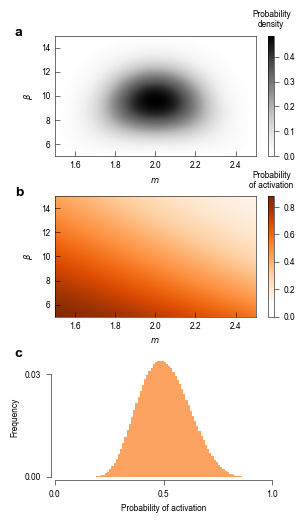

In [25]:
# Fig 3/3
# grid
NX = 101
NY = 1001
xmax = 2.5
xmin = 1.5
ymax = 15
ymin = 5
dx = (xmax-xmin)/(NX-1)
dy = (ymax-ymin)/(NY-1)

# load data
dataw = pd.read_csv('%sFokker_planck_solution.csv.gz' %
                    (DATA_FOLDER), compression='gzip')
col = dataw.columns[-1]
w = dataw[col]
w = np.array(w).reshape((NX, NY))
data = pd.read_csv('%spoa_matrix.csv.gz' % (DATA_FOLDER), compression='gzip')
poa = np.array(data['Poa']).reshape((NX, NY))

# plotting ---------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.5))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
h = 0.24
s = 0.08
ax1 = fig.add_axes([0.15, 0.95 - h, 0.75, h])
ax2 = fig.add_axes([0.15, 0.95 - 2*h - s, 0.75, h])
ax3 = fig.add_axes([0.15, 0.95 - 3*h - 2*s, 0.65, h])
fig.text(
    0.03, 0.95, string.ascii_uppercase[0].lower(), size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.03, 0.95 - (h+s), string.ascii_uppercase[1].lower(), size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.03, 0.95 - 2*(h+s), string.ascii_uppercase[2].lower(), size=SUBLABEL_SIZE, weight='bold')
ax1.tick_params(direction='in')
ax2.tick_params(direction='in')

ax1.set_xlabel(r'$m$')
ax1.set_ylabel(r'$\beta$')
ax2.set_xlabel(r'$m$')
ax2.set_ylabel(r'$\beta$')

ax3.set_xlabel(POA_LABEL)
ax3.set_ylabel('Frequency')
ax3.set_xlim([0, 1])
ax3.set_ylim([-0.0002, 0.035])
ax3.set_yticks([0, 0.03])
ax3.spines['left'].set_bounds(0, 0.03)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
X = xmin+dx*np.arange(NX)
Y = ymin+dy*np.arange(NY)

colorinterpolation = 50  # Set colour interpolation and colour map
pos1 = ax1.pcolormesh(X, Y, w.T, shading='gouraud',
                      cmap=plt.cm.get_cmap('Greys'))
cbar1 = fig.colorbar(pos1, ax=ax1)
cbar1.ax.set_title('Probability\ndensity', fontsize=LABEL_SIZE)
cbar1.set_ticks(np.arange(0, 0.5, step=0.1))

pos2 = ax2.pcolormesh(X, Y, poa.T, shading='gouraud',
                      cmap=plt.cm.get_cmap('Oranges'))
cbar2 = fig.colorbar(pos2, ax=ax2)
cbar2.ax.set_title('Probability\nof activation', fontsize=LABEL_SIZE)
cbar2.set_ticks(np.arange(0, 1, step=0.2))

poa_c = sns.color_palette('Oranges', n_colors=1)

# bins for poa histgram
binstep = 0.01
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)
xbin = []
y3 = []
for ibin in range(int(1.0/binstep)):
    xbin.append((ibin+0.5)*binstep)
    y3.append(0)
for ix in range(NX):
    for iy in range(NY):
        ibin = 0
        while ibin*binstep < poa[ix, iy]:
            ibin += 1
        y3[ibin] += w[ix, iy]
y3plot = [float(i)/sum(y3) for i in y3]
ax3.bar(xbin, height=y3plot, width=binstep, align='center', alpha=0.8, facecolor=poa_c[0])
ax3.set_xticks([0, 0.5, 1])

plt.savefig('figures/figs2-heterogeneity.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Supplementary Figure 3. Immune cells responses are diverse

## Part 1. Evolution of the probability distibution of ($\mu$, $\beta$)

In [11]:
if FRESH_RUN:
    def update_mubeta(initial_mean, initial_beta, alpha, kappa, num_encounter, m_env, var_env):
        c1 = (alpha-1)/(alpha-0.5) # constant in betanew = c1*beta + c2*(x-mu)**2
        c2 = 0.5*(alpha-1)/(alpha-0.5)*kappa/(kappa+1)
        mean_old = initial_mean
        beta_old = initial_beta
        for nstep in range(1, num_encounter):
            x = random.gauss(m_env, np.sqrt(var_env))  # gauss(mean,std)
            mean_new = (kappa*mean_old+x)/(kappa+1)
            beta_new = c1*beta_old+c2*(x-mean_old)**2
            mean_old, beta_old = mean_new, beta_new
        return(mean_new, beta_new)


    # variables
    num_cells = 100000  
    num_encounter = 1000
    m_env = 2
    var_env = 1
    u2s = [6, 5, 4, 3]
    alpha_vals = [5, 10, 20, 50]
    var2 = 1
    num_u2s = len(u2s)

    df = pd.DataFrame({'alpha': [],
                       'Cell No': [],
                       'Antigen mean': [],
                       'Antigen std': [],
                       'M': [],
                       'Beta': [],
                       'Poa': []
                       })
    datatype_dict = {'alpha': int,
                     'Cell No': int,
                     'Antigen mean': float,
                     'Antigen std': float,
                     'M': float,
                     'Beta': float,
                     'Poa': float
                     }
    df = df.astype(datatype_dict)

    # initial distribution form and number of NK cells
    init_m = [0]*num_cells
    init_beta = [0]*num_cells
    for i in range(num_cells):
        init_m[i] = random.random()*5  # [0,5)
        init_beta[i] = random.random()*40  # [0,40)

    # loop to get m beta distribution after num_encounter steps
    for u2 in u2s:
        print('target mean', u2)
        for alpha in alpha_vals:
            print('alpha', alpha)
            print(timer())
            kappa = 2*alpha
            m = np.zeros(num_cells)
            beta = np.zeros(num_cells)
            poa = np.zeros(num_cells)
            for i_cell in range(num_cells):
                if i_cell % 10000 == 0:
                    print(i_cell, timer())
                m[i_cell], beta[i_cell] = update_mubeta(init_m[i_cell], init_beta[i_cell],
                                                        alpha, kappa, num_encounter, m_env, var_env)
                poa[i_cell] = POA(alpha, kappa, m[i_cell], beta[i_cell], u2, var2)
            df2 = pd.DataFrame({'alpha': [alpha]*num_cells,
                                'Cell No': np.arange(num_cells),
                                'Antigen mean': [u2]*num_cells,
                                'Antigen std': [var2]*num_cells,
                                'M': m,
                                'Beta': beta,
                                'Poa': poa
                                })
            df = pd.concat([df, df2])
    df.to_csv('%sdiff_memory_population.csv.gz', % DATA_FOLDER,
              index=None, header=True, compression='gzip')
    print('update mu beta done')

## Part 2. Plotting

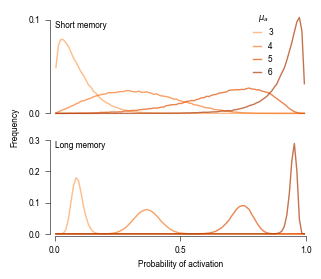

In [12]:
# different memory length, NK cell response are heterogeneous
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
data = pd.read_csv('%sdiff_memory_population.csv.gz' %
                   DATA_FOLDER, compression='gzip')

alpha_vals = [5, 10, 20, 50]
num_cells = 100000

# bins and bar middle points
binstep = 0.01
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)
x = []
for ibin in range(int(1.0/binstep)):
    x.append((ibin+0.5)*binstep)

# figure size
w = 0.75
h = 0.35

fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
fig.text(0.03, 0.55, 'Frequency', rotation='vertical',
         ha='center', va='center', fontsize=LABEL_SIZE)
fig.text(0.15, 0.93, 'Short memory',
         ha='left', va='center', fontsize=LABEL_SIZE)
fig.text(0.15, 0.83-h, 'Long memory',
         ha='left', va='center', fontsize=LABEL_SIZE)

ax1 = fig.add_axes([0.15, 0.95-1*h, w, h])
ax2 = fig.add_axes([0.15, 0.85-2*h, w, h])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))

ax1.set_xlim([0, 1])
ax2.set_xlim([0, 1])
ax1.set_ylim([0, 0.10])
ax2.set_ylim([0, 0.30])
ax1.set_yticks([0, 0.1])
ax2.set_yticks([0, 0.1, 0.2, 0.3])

ax1.set_xticks([])
ax2.set_xticks(np.arange(0, 1.01, step=0.5))
ax1.tick_params(top=False, labelbottom=False)
ax2.set_xlabel(POA_LABEL)

poa_c = sns.color_palette('Oranges', n_colors=6)

u_vals = [3, 4, 5, 6]

for i in range(len(u_vals)):
    poas = data.loc[(data['Antigen mean'] == u_vals[i]) &
                    (data['alpha'] == 5)]['Poa']
    y = np.histogram(poas, bins)[0]/num_cells
    ax1.plot(x, y, alpha=0.7, clip_on=False, c=poa_c[i+2], label=u_vals[i])

    poas = data.loc[(data['Antigen mean'] == u_vals[i]) &
                    (data['alpha'] == 50)]['Poa']
    y = np.histogram(poas, bins)[0]/num_cells
    ax2.plot(x, y, alpha=0.7, clip_on=False, c=poa_c[i+2])

ax1.legend(title=r'$\mu_a$', loc='center', bbox_to_anchor=(
    0.83, 0.73), borderaxespad=0, ncol=1, handlelength=1, frameon=False)


plt.savefig('figures/figs3-heterogeneity-response.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Supplementary Figure 1. Immune cells adapt to a static environment

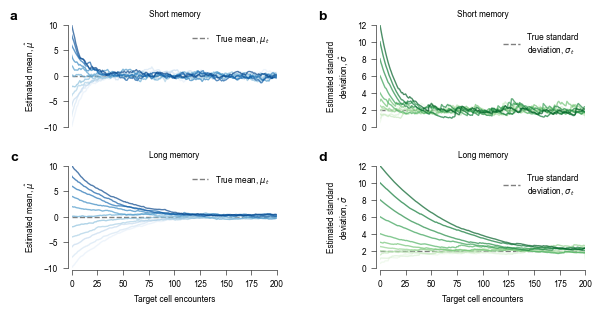

In [13]:
# SI Fig 1  different memory
# Compare alpha = 5 vs 20

alphas = [5, 20]
kappas = [10, 40]
alpha_shortmem = 5
kappa_shortmem = 10
alpha_longmem = 20
kappa_longmem = 40
m_env = 0
var_env = 4
num_encounter = 200

initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)

initial_mean = 0
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)

if __name__ == '__main__':
    fig = plt.figure(figsize=(DOUBLE_COLUMN, 3))
    plt.rc('font', size=LABEL_SIZE, family=FAMILY)
    ax1 = fig.add_axes([0.15, 0.59, 0.3, 0.34])
    ax2 = fig.add_axes([0.15, 0.12, 0.3, 0.34])
    ax3 = fig.add_axes([0.60, 0.59, 0.3, 0.34])
    ax4 = fig.add_axes([0.60, 0.12, 0.3, 0.34])
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.axes.get_xaxis().set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax1.spines['left'].set_position(('axes', -0.02))
    ax3.spines['left'].set_position(('axes', -0.02))
    ax2.spines['bottom'].set_position(('axes', -0.02))
    ax2.spines['left'].set_position(('axes', -0.02))
    ax4.spines['bottom'].set_position(('axes', -0.02))
    ax4.spines['left'].set_position(('axes', -0.02))
    ax1.set_xlim([0, num_encounter])
    ax1.set_ylim([-10, 10])
    ax2.set_xlim([0, num_encounter])
    ax2.set_ylim([-10, 10])
    ax3.set_xlim([0, num_encounter])
    ax3.set_ylim([0, 12])
    ax4.set_xlim([0, num_encounter])
    ax4.set_ylim([0, 12])

    ax1.axhline(m_env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
    ax1.legend(loc='upper right', frameon=False)
    ax1.set_ylabel('Estimated mean, $\hat{\mu}$', fontsize=LABEL_SIZE)
    ax1.text(-0.3, 1.05, string.ascii_uppercase[0].lower(),
             transform=ax1.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax1.set_title(r'Short memory', fontsize=LABEL_SIZE)

    ax2.axhline(m_env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
    ax2.legend(loc='upper right', frameon=False)
    ax2.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
    ax2.set_ylabel('Estimated mean, $\hat{\mu}$', fontsize=LABEL_SIZE)
    ax2.text(-0.3, 1.05, string.ascii_uppercase[2].lower(),
             transform=ax2.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax2.set_title(r'Long memory', fontsize=LABEL_SIZE)

    ax3.axhline(np.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
    ax3.legend(loc='upper right', frameon=False)
    ax3.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
    ax3.text(-0.3, 1.05, string.ascii_uppercase[1].lower(),
             transform=ax3.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax3.set_title(r'Short memory', fontsize=LABEL_SIZE)

    ax4.axhline(np.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
    ax4.legend(loc='upper right', frameon=False)
    ax4.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
    ax4.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
    ax4.text(-0.3, 1.05, string.ascii_uppercase[3].lower(),
             transform=ax4.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax4.set_title(r'Long memory', fontsize=LABEL_SIZE)

    # different initial mean and same var ------------------------------------
    
    mu_c = sns.color_palette('Blues', n_colors=num_means)
    std_c = sns.color_palette('Greens', n_colors=num_stds)
    
    data = pd.read_csv('%sestimated_mean_std.csv.gz' %
                       DATA_FOLDER, compression='gzip')
    for j_mu in range(num_means):
        mean_shortmem = data.loc[(data['alpha'] == alpha_shortmem) &
                                 (data['kappa'] == kappa_shortmem) &
                                 (data['Initial mean'] == initial_means[j_mu]) &
                                 (data['Initial std'] == initial_std)]['Mean']
        encouner = range(len(mean_shortmem))
        ax1.plot(encouner, mean_shortmem, alpha = 0.7, c = mu_c[j_mu])
        mean_longmem = data.loc[(data['alpha'] == alpha_longmem) &
                                (data['kappa'] == kappa_longmem) &
                                (data['Initial mean'] == initial_means[j_mu]) &
                                (data['Initial std'] == initial_std)]['Mean']
        encouner = range(len(mean_longmem))
        ax2.plot(encouner, mean_longmem, alpha = 0.7, c = mu_c[j_mu])
	# different initial std and same mean ------------------------------------
    for j_std in range(num_stds):
        std_shortmem = data.loc[(data['alpha'] == alpha_shortmem) &
                                (data['kappa'] == kappa_shortmem) &
                                (data['Initial mean'] == initial_mean) &
                                (data['Initial std'] == initial_stds[j_std])]['Std']
        encounter = range(len(std_shortmem))
        ax3.plot(encounter, std_shortmem, alpha = 0.7, c = std_c[j_std])
        std_longmem = data.loc[(data['alpha'] == alpha_longmem) &
                               (data['kappa'] == kappa_longmem) &
                               (data['Initial mean'] == initial_mean) &
                               (data['Initial std'] == initial_stds[j_std])]['Std']
        encounter = range(len(std_longmem))
        ax4.plot(encounter, std_longmem, alpha = 0.7, c = std_c[j_std])
    plt.savefig('figures/figs1-adaptation-memory.pdf', format='pdf', dpi=300)
    plt.show()
    plt.close()

# Supplementary Figure 4. Finite memory of past interactions with target cells results in heterogeneous behaviors

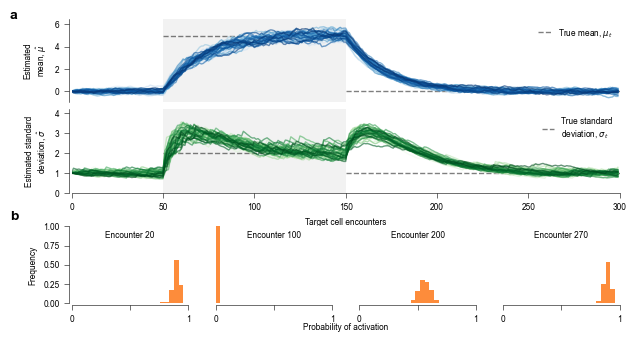

In [14]:
# Fig S4

num_cell = 500
num_lines = 50
alpha = 10
kappa = 20
m_env1 = 0
var_env1 = 1
m_env2 = 5
var_env2 = 4
num1env = 50
num2env = 100
num3env = 150
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
total_num = num1env+num2env+num3env

# load data
data = pd.read_csv(
    '%sMultiEnvs_MultiCells_mean_std_beta_poa.csv.gz' % (DATA_FOLDER), compression='gzip')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(DOUBLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
fig.text(
    0.05, 0.95, string.ascii_uppercase[0].lower(), size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.05, 0.35, string.ascii_uppercase[1].lower(), size=SUBLABEL_SIZE, weight='bold')

ax1 = fig.add_axes([0.14, 0.7, 0.8, 0.25])
ax2 = fig.add_axes([0.14, 0.43, 0.8, 0.25])
ax3 = fig.add_axes([0.14, 0.1, 0.17, 0.23])
ax4 = fig.add_axes([0.35, 0.1, 0.17, 0.23])
ax5 = fig.add_axes([0.56, 0.1, 0.17, 0.23])
ax6 = fig.add_axes([0.77, 0.1, 0.17, 0.23])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['left'].set_position(('axes', -0.005))
ax1.spines['bottom'].set_position(('axes', -0.005))
ax2.spines['left'].set_position(('axes', -0.005))
ax2.spines['bottom'].set_position(('axes', -0.005))
ax1.set_ylim(-1, 6.5)
ax2.set_ylim(0, 4.2)
ax1.set_xlim(0, 300)
ax2.set_xlim(0, 300)
ax1.set_xticks([])

ax1.axvspan(50, 150, alpha=0.1, color='grey', lw=0)
ax2.axvspan(50, 150, alpha=0.1, color='grey', lw=0)
ax1.hlines(0, xmin=-10, xmax=num1env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
ax1.hlines(5, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax1.hlines(0, xmin=num1env+num2env, xmax=num1env+num2env+num3env, **DASH_STYLE)
ax2.hlines(y=1, xmin=-10, xmax=num1env, label=TRUE_STD_LABEL, **DASH_STYLE)
ax2.hlines(y=2, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax2.hlines(y=1, xmin=num1env+num2env, xmax=num1env +
           num2env+num3env, **DASH_STYLE)
ax1.legend(loc='upper right', frameon=False, handlelength=1.5)
ax2.legend(loc='upper right', frameon=False, handlelength=1.5)

mu_c = sns.color_palette('Blues', n_colors=num_lines)
std_c = sns.color_palette('Greens', n_colors=num_lines)
for i_cell in range(num_lines):
    ax1.plot(np.arange(total_num),
             data.loc[data['Cell No'] == i_cell]['Mean'], alpha=0.6, c=mu_c[i_cell])
ax1.set_ylabel(ESTD_MEAN_LABEL)

for i_cell in range(num_lines):
    ax2.plot(np.arange(total_num),
             data.loc[data['Cell No'] == i_cell]['Std'], alpha=0.6, c=std_c[i_cell])
ax2.set_ylabel(ESTD_STD_LABEL)

ax2.set_xlabel(ENCOUNTER_LABEL)

ax3.set_xticks(np.arange(0, 1.01, step=0.5))
ax4.set_xticks(np.arange(0, 1.01, step=0.5))
ax5.set_xticks(np.arange(0, 1.01, step=0.5))
ax6.set_xticks(np.arange(0, 1.01, step=0.5))
ax3.set_xticklabels(['0', '', '1'])
ax4.set_xticklabels(['0', '', '1'])
ax5.set_xticklabels(['0', '', '1'])
ax6.set_xticklabels(['0', '', '1'])
ax3.set_ylim([0, 1])
ax4.set_ylim([0, 1])
ax5.set_ylim([0, 1])
ax6.set_ylim([0, 1])
ax3.set_xlim([0, 1])
ax4.set_xlim([0, 1])
ax5.set_xlim([0, 1])
ax6.set_xlim([0, 1])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax3.spines['left'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax4.spines['bottom'].set_position(('axes', -0.02))
ax5.spines['bottom'].set_position(('axes', -0.02))
ax6.spines['bottom'].set_position(('axes', -0.02))

ax3.set_ylabel('Frequency')
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])

binstep = 0.04
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)

xbins = []
for ibin in range(int(1.0/binstep)):
    xbins.append(binstep*ibin)

# -----------------------------

step_vals = [20, 100, 200, 270]
axes = [ax3, ax4, ax5, ax6]

poa_c = sns.color_palette('Oranges', n_colors=1)[0]

for nstep, ax in zip(step_vals, axes):
    pointpoas = data.loc[data['Encounters'] == nstep]['Poa']
    statist = np.histogram(pointpoas, bins)[0]/num_cell
    ax.bar(xbins, height=statist, width=binstep, align='edge', fc=poa_c)
    ax.text(0.5, 0.85, 'Encounter %d' %
            nstep, ha='center', fontsize=LABEL_SIZE, color='k')

# ----------------------
fig.text(0.54, 0.02, POA_LABEL, ha='center')
plt.savefig('figures/figs4-adaptation-dynamic-population.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Supplementary Figure 5. Adaptation with signal saturation

## Part 1. Generating data

In [15]:
if FRESH_RUN:
    # variables
    alpha = 10
    kappa = 20
    m_env = 0
    var_env = 4
    num_encounter = 200

    df = pd.DataFrame({'Initial mean': [],
                       'Initial std': [],
                       'True mean': [],
                       'True std': [],
                       'alpha': [],
                       'kappa': [],
                       'Encounters': [],
                       'Mean': [],
                       'Std': []
                       })
    datatype_dict = {'Initial mean': float,
                     'Initial std': float,
                     'True mean': float,
                     'True std': float,
                     'alpha': int,
                     'kappa': int,
                     'Encounters': int,
                     'Mean': float,
                     'Std': float
                     }
    df = df.astype(datatype_dict)

    # case 1. initial different mean and same var ------------------------------------
    initial_means = np.arange(-10, 11, 2)
    initial_std = 1
    num_means = len(initial_means)
    for i_case in range(num_means):
        initial_mean = initial_means[i_case]
        mean, std = UPDATE_ALT(initial_mean, initial_std, alpha,
                            kappa, num_encounter, m_env, var_env)
        num_rows = len(mean)
        df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
                            'Initial std': [initial_std]*num_rows,
                            'True mean': [m_env]*num_rows,
                            'True std': [np.sqrt(var_env)]*num_rows,
                            'alpha': [alpha]*num_rows,
                            'kappa': [kappa]*num_rows,
                            'Encounters': np.arange(num_rows),
                            'Mean': mean,
                            'Std': std
                            })
        df = pd.concat([df, df2])

    # case 2. initial same mean and different var ------------------------------------
    initial_mean = 0
    initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
    num_stds = len(initial_stds)
    for i_case in range(num_means, num_means+num_stds):
        initial_std = initial_stds[i_case-num_means]
        mean, std = UPDATE_ALT(initial_mean, initial_std, alpha,
                            kappa, num_encounter, m_env, var_env)
        num_rows = len(mean)
        df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
                            'Initial std': [initial_std]*num_rows,
                            'True mean': [m_env]*num_rows,
                            'True std': [np.sqrt(var_env)]*num_rows,
                            'alpha': [alpha]*num_rows,
                            'kappa': [kappa]*num_rows,
                            'Encounters': np.arange(num_rows),
                            'Mean': mean,
                            'Std': std
                            })
        df = pd.concat([df, df2])

    df.to_csv('%sSI3_estimated_mean_std_alpha%d.csv.gz' %
              (DATA_FOLDER, alpha), index=None, header=True, compression='gzip')
    print('Fig SI 3 data done')

## Part 2. Plotting Supplementary Figure 5

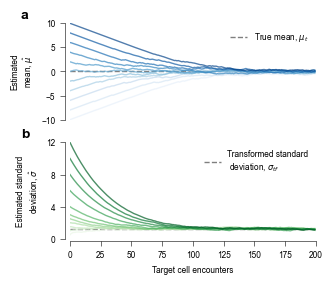

In [16]:
alpha = 10  
kappa = 20 
m_env = 0
var_env = 4
std_tf = TRANSFORMED_STD(2, np.sqrt(var_env)) # calculater transformed std
num_encounter = 200

initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)

initial_mean = 0
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)

# read data
data = pd.read_csv('%sSI3_estimated_mean_std_alpha%d.csv.gz' %
                   (DATA_FOLDER, 10), compression='gzip')

# Plotting -----------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))

ax1 = fig.add_axes([0.20, 0.57, 0.735, 0.36])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.set_xlim([0, num_encounter])
ax1.set_ylim([-10, 10])
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_ylabel(ESTD_MEAN_LABEL, fontsize=LABEL_SIZE)
ax1.text(-0.2, 1.05, string.ascii_uppercase[0].lower(),
         transform=ax1.transAxes, size=SUBLABEL_SIZE, weight='bold')
ax1.axhline(0.0, label=TRUE_MEAN_LABEL, **DASH_STYLE)

ax2 = fig.add_axes([0.20, 0.125, 0.735, 0.36])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.set_xlim([0, num_encounter])
ax2.set_ylim([0, 12])
ax2.set_yticks([0, 4, 8, 12])
ax2.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
ax2.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
ax2.text(-0.2, 1.05, string.ascii_uppercase[1].lower(),
         transform=ax2.transAxes, size=SUBLABEL_SIZE, weight='bold')
ax2.axhline(
    std_tf, label='Transformed standard\n deviation, $\sigma_{tf}$', **DASH_STYLE)
ax1.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)

mu_c = sns.color_palette('Blues', n_colors=num_means)
std_c = sns.color_palette('Greens', n_colors=num_stds)

# Case 1 different means and same variance ---------------
for j_mu in range(num_means):
    mean = data.loc[(data['alpha'] == alpha) & (data['Initial mean'] == initial_means[j_mu]) 
                    & (data['Initial std'] == initial_std)]['Mean']
    encouner = range(len(mean))
    ax1.plot(encouner, mean, alpha = 0.7, c = mu_c[j_mu])

# Case 2 initial same mu and different var ---------------
for j_std in range(num_stds):
    std = data.loc[(data['alpha'] == alpha) & (data['Initial mean'] == initial_mean) 
                   & (data['Initial std'] == initial_stds[j_std])]['Std']
    encounter = range(len(std))
    ax2.plot(encounter, std, alpha = 0.7, c = std_c[j_std])

plt.savefig('figures/figs5-adaptation-static.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Supplementary Figure 6. Adaptation with signal saturation

## Part 1. Generating data

In [17]:
if FRESH_RUN:
    alpha = 10
    kappa = 20
    varc1 = (alpha-1)/(alpha-0.5)
    varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
    m_env1 = 0
    var_env1 = 1
    m_env2 = 5
    var_env2 = 4
    num1env = 50
    num2env = 150
    num3env = 150
    total_num = num1env+num2env+num3env

    mean = [0]*total_num
    std = [0]*total_num
    poa = [0]*total_num
    beta = [0]*total_num
    mean[0] = m_env1
    std[0] = np.sqrt(var_env1)
    beta[0] = std[0]**2*(alpha-1)
    poa[0] = (POA(alpha, kappa, mean[0], beta[0], m_env2, var_env2))

    # healthy environment
    mean, std = UPDATE_ALT(m_env1, np.sqrt(var_env1), alpha,
                           kappa, num1env, m_env1, var_env1)

    # unhealthy environment
    a, b = UPDATE_ALT(mean[-1], std[-1], alpha, kappa, num2env, m_env2, var_env2)
    mean += a
    std += b

    # healthy environment
    a, b = UPDATE_ALT(mean[-1], std[-1], alpha, kappa, num3env, m_env1, var_env1)
    mean += a
    std += b

    # calculate the poa
    for nstep in range(total_num):
        beta[nstep] = std[nstep]**2*(alpha-1)
        poa[nstep] = POA(alpha, kappa, mean[nstep],
                         beta[nstep], m_env2, var_env2)

    # data saving ----------------------------------------------------
    df = pd.DataFrame()
    df['alpha'] = [alpha]*total_num
    df['kappa'] = [kappa]*total_num
    df['True mean'] = [m_env1]*num1env+[m_env2]*num2env+[m_env1]*num3env
    df['True std'] = [np.sqrt(var_env1)]*num1env + \
        [np.sqrt(var_env2)]*num2env+[np.sqrt(var_env1)]*num3env
    df['Mean'] = mean
    df['Std'] = std
    df['Beta'] = beta
    df['Poa'] = poa
    df.to_csv('%sSI4_MultiEnvs_mean_std_beta_poa.csv.gz' % DATA_FOLDER,
              index=None, header=True, compression='gzip')
    print('Fig SI 4 data done')

## Part 2. Plotting Supplementary Figure 6

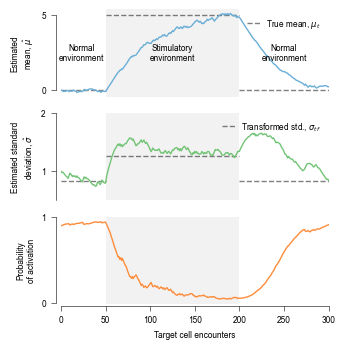

In [18]:
# SI Fig 6 plot

alpha = 10
kappa = 20
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1 = 0
var_env1 = 1
std_1_tf = TRANSFORMED_STD(2, np.sqrt(var_env1))  # calculater transformed std
m_env2 = 5
var_env2 = 4
std_2_tf = TRANSFORMED_STD(2, np.sqrt(var_env2))
num1env = 50
num2env = 150
num3env = 150
total_num = num1env+num2env+num3env

# load data
data = pd.read_csv('%sSI4_MultiEnvs_mean_std_beta_poa.csv.gz' %
                   (DATA_FOLDER), compression='gzip')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.0))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.165, 0.73, 0.8, 0.26])
ax2 = fig.add_axes([0.165, 0.42, 0.8, 0.26])
ax3 = fig.add_axes([0.165, 0.11, 0.8, 0.26])
ax1.tick_params(top=False, labelbottom=False)
ax2.tick_params(top=False, labelbottom=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax3.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax1.set_xlim(0, 300)
ax2.set_xlim(0, 300)
ax3.set_xlim(0, 300)
ax1.set_yticks([0, 5])
ax1.set_yticklabels([0, 5])
ax2.set_yticks([1, 2])
ax2.set_yticklabels([1, 2])
ax2.set_ylim(0.5, 2)
ax3.set_yticks([0, 1])
ax1.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)
ax2.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)
ax3.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)

ax1.hlines(y=m_env1, xmin=0, xmax=num1env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
ax1.hlines(y=m_env2, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax1.hlines(y=m_env1, xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)

ax2.hlines(y=std_1_tf, xmin=0, xmax=num1env,
           label='Transformed std., $\sigma_{tf}$', **DASH_STYLE)
ax2.hlines(y=std_2_tf, xmin=num1env,
           xmax=num1env+num2env, **DASH_STYLE)
ax2.hlines(y=std_1_tf, xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)

ax1.spines['left'].set_bounds(0, 5)
ax2.spines['left'].set_bounds(0.5, 2)
ax3.set_ylim(-0.01, 1)
ax3.spines['left'].set_bounds(0, 1)

ax3.set_ylim(-0.01, 1)
ax1.text(23, 2.5, 'Normal\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)
ax1.text(125, 2.5, 'Stimulatory\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)
ax1.text(250, 2.5, 'Normal\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)

mu_c = sns.color_palette('Blues', n_colors=1)
std_c = sns.color_palette('Greens', n_colors=1)
poa_c = sns.color_palette('Oranges', n_colors=1)

ax1.legend(loc='upper right', frameon=False, handlelength=1.5)
ax2.legend(loc='upper right', frameon=False, handlelength=1.5)
ax1.plot(data['Mean'], c=mu_c[0])
ax1.set_ylabel(ESTD_MEAN_LABEL)
ax2.plot(data['Std'], c=std_c[0])
ax2.set_ylabel(ESTD_STD_LABEL)
ax3.plot(data['Poa'], c=poa_c[0])
ax3.set_xlabel(ENCOUNTER_LABEL)
ax3.set_ylabel('Probability\nof activation')
plt.savefig('figures/figs6-adaptation-dynamic.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# New Figure 1
### Effects of sparse receptor expression on target recognition

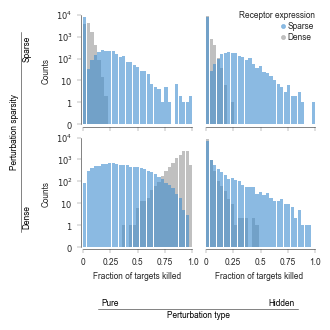

In [12]:
N_SAMPLES = 10000  # number of target cells
N_CELLS   = 10000  # number of immune cells
BINOM_P   = 0.22   # binomial receptor expression probability

w       = SINGLE_COLUMN
hshrink = 1.0
goldh   = w * hshrink
fig     = plt.figure(figsize=(w, goldh))

box_top    = 0.95
box_bottom = 0.25
box_left   = 0.25
box_right  = 0.95

box_hist = dict(left=box_left, right=box_right, bottom=box_bottom, top=box_top)
gs_hist  = gridspec.GridSpec(2, 2, wspace=0.10, hspace=0.10, **box_hist)

psparsity = ['sparse', 'dense']
ptype = ['pure', 'hidden']
prof = 'binary'
scale = 5
idx = 0

for i_idx in range(len(psparsity)):
    for j_idx in range(len(ptype)):
        data = np.load('%s/response_%s_%s_%s_%d_perturb_%d.npz' %
               (DATA_FOLDER, prof, psparsity[i_idx], ptype[j_idx], scale, idx))
        sparse_act = data['binom']
        dense_act  = data['uniform']

        sparse_n = np.array([np.sum(i)/N_SAMPLES for i in sparse_act])
        dense_n  = np.array([np.sum(i)/N_SAMPLES for i in  dense_act])

        p_max = 1
        n_bins = 31
        bin_dp = p_max / n_bins
        bins = np.arange(0, p_max+bin_dp, bin_dp)
        
        sparse_y = [np.sum((bins[i]<=sparse_n) & (sparse_n<bins[i+1])) for i in range(len(bins)-1)]
        sparse_y.append(np.sum(sparse_n>=bins[-1]))
        
        dense_y = [np.sum((bins[i]<=dense_n) & (dense_n<bins[i+1])) for i in range(len(bins)-1)]
        dense_y.append(np.sum(dense_n>=bins[-1]))
        
        for i in range(len(sparse_y)):
            if sparse_y[i]>0:
                sparse_y[i] = 1 + np.log10(sparse_y[i])
            else:
                sparse_y[i] = 0
                
        for i in range(len(dense_y)):
            if dense_y[i]>0:
                dense_y[i] = 1 + np.log10(dense_y[i])
            else:
                dense_y[i] = 0
                
        hist_props = dict(lw=AXWIDTH/2, width=0.9*p_max/n_bins, align='center', alpha=0.6,
                          orientation='vertical')#, edgecolor=[BKCOLOR])

        pprops = { 'xlim':        [0, p_max],
                   'xticks':      [ 0, 0.25, 0.5, 0.75, 1.0],
                   'xticklabels': ['',   '',  '',   '',  ''],
                   'ylim':        [0, 5],
                   'yticks':      [],
                   'colors':      [COLOR_ONE, LCOLOR],
                   'plotprops':   hist_props,
                   'axoffset':    0.1,
                   'theme':       'open',
                   'hide':        ['left'] }

        if j_idx==0:
            pprops['yticks']      = [0, 1, 2, 3, 4, 5]
            pprops['yticklabels'] = [r'$0$', r'$1$', r'$10$', r'$10^2$', r'$10^3$', r'$10^4$']
            pprops['ylabel']      = 'Counts'
            pprops['hide'].remove('left')

        if i_idx==1:
            pprops['xticklabels'] = [ 0, 0.25, 0.5, 0.75, 1.0]
            pprops['xlabel']      = 'Fraction of targets killed'

        ax = plt.subplot(gs_hist[i_idx, j_idx])
        mp.plot(type='bar', ax=ax, x=[bins+(bin_dp/2), bins+(bin_dp/2)], y=[sparse_y, dense_y], **pprops)
        
        # legend

        if i_idx==0 and j_idx==1:
            legend_x  =  0.75
            legend_d  = -0.04
            legend_y  = 4.5
            legend_dy = 0.5
            plotprops = dict(mew=AXWIDTH, markersize=SMALLSIZEDOT/2, fmt='o', elinewidth=SIZELINE/2, 
                             capthick=0, capsize=0, clip_on=False, alpha=0.6)

            ax.text(1.0, legend_y + legend_dy, 'Receptor expression', ha='right', va='center', **DEF_LABELPROPS)
            mp.error(ax=ax, x=[[legend_x + legend_d]], y=[[legend_y]], 
                     colors=[COLOR_ONE], plotprops=plotprops)
            ax.text(legend_x, legend_y, 'Sparse', ha='left', va='center', **DEF_LABELPROPS)
            mp.error(ax=ax, x=[[legend_x + legend_d]], y=[[legend_y - legend_dy]],
                     colors=[LCOLOR], plotprops=plotprops)
            ax.text(legend_x, legend_y - legend_dy, 'Dense', ha='left', va='center', **DEF_LABELPROPS)
                

lprops = dict(lw=AXWIDTH, ls='-', transform=fig.transFigure, clip_on=False)
xy = 0.07
dxy = 0.05
mp.line(ax=ax, x=[[xy, xy]], y=[[box_top-dxy, box_bottom+dxy]], colors=[BKCOLOR], plotprops=lprops)
mp.line(ax=ax, x=[[box_left+dxy, box_right-dxy]], y=[[xy, xy]], colors=[BKCOLOR], plotprops=lprops)
            
tprops = dict(family=FONTFAMILY, size=SIZELABEL, transform=fig.transFigure, clip_on=False)
ddxy = 0.005
ax.text(xy-ddxy, (box_top+box_bottom)/2, 'Perturbation sparsity', rotation=90, ha='right', va='center', **tprops)
ax.text(xy+ddxy, box_top-dxy-2*ddxy, 'Sparse', rotation=90, ha='left', va='top', **tprops)
ax.text(xy+ddxy, box_bottom+dxy+2*ddxy, 'Dense', rotation=90, ha='left', va='bottom', **tprops)
ax.text((box_left+box_right)/2, xy-ddxy, 'Perturbation type', rotation=0, ha='center', va='top', **tprops)
ax.text(box_left+dxy+2*ddxy, xy+ddxy, 'Pure', rotation=0, ha='left', va='bottom', **tprops)
ax.text(box_right-dxy-2*ddxy, xy+ddxy, 'Hidden', rotation=0, ha='right', va='bottom', **tprops)

            
# SAVE FIGURE

plt.savefig('figures/fig5-highdim-%s.pdf' % prof, dpi=1000, facecolor=fig.get_facecolor(), edgecolor=None, **FIGPROPS)
plt.show()
plt.close(fig)

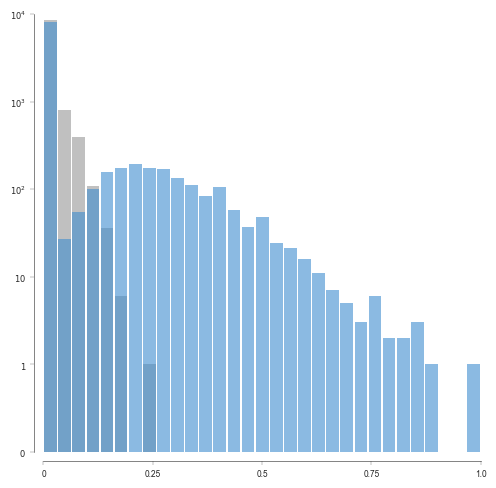

In [20]:
N_SAMPLES = 10000  # number of target cells
N_CELLS   = 10000  # number of immune cells
BINOM_P   = 0.22   # binomial receptor expression probability

w       = SLIDE_WIDTH/2
hshrink = 1.0
goldh   = w * hshrink
fig     = plt.figure(figsize=(w, goldh))

box_top    = 0.95
box_bottom = 0.10
box_left   = 0.10
box_right  = 0.95

box_hist = dict(left=box_left, right=box_right, bottom=box_bottom, top=box_top)
gs_hist  = gridspec.GridSpec(1, 1, wspace=0.10, hspace=0.10, **box_hist)

psparsity = ['sparse', 'dense']
ptype = ['pure', 'hidden']
prof = 'binary'
scale = 5
idx = 0

psparsity = ['sparse']
ptype = ['hidden']

for i_idx in range(len(psparsity)):
    for j_idx in range(len(ptype)):
        data = np.load('%s/response_%s_%s_%s_%d_perturb_%d.npz' %
               (DATA_FOLDER, prof, psparsity[i_idx], ptype[j_idx], scale, idx))
        sparse_act = data['binom']
        dense_act  = data['uniform']

        sparse_n = np.array([np.sum(i)/N_SAMPLES for i in sparse_act])
        dense_n  = np.array([np.sum(i)/N_SAMPLES for i in  dense_act])

        p_max = 1
        n_bins = 31
        bin_dp = p_max / n_bins
        bins = np.arange(0, p_max+bin_dp, bin_dp)
        
        sparse_y = [np.sum((bins[i]<=sparse_n) & (sparse_n<bins[i+1])) for i in range(len(bins)-1)]
        sparse_y.append(np.sum(sparse_n>=bins[-1]))
        
        dense_y = [np.sum((bins[i]<=dense_n) & (dense_n<bins[i+1])) for i in range(len(bins)-1)]
        dense_y.append(np.sum(dense_n>=bins[-1]))
        
        for i in range(len(sparse_y)):
            if sparse_y[i]>0:
                sparse_y[i] = 1 + np.log10(sparse_y[i])
            else:
                sparse_y[i] = 0
                
        for i in range(len(dense_y)):
            if dense_y[i]>0:
                dense_y[i] = 1 + np.log10(dense_y[i])
            else:
                dense_y[i] = 0
                
        hist_props = dict(lw=AXWIDTH/2, width=0.9*p_max/n_bins, align='center', alpha=0.6,
                          orientation='vertical')#, edgecolor=[BKCOLOR])

        pprops = { 'xlim':        [0, p_max],
                   'xticks':      [ 0, 0.25, 0.5, 0.75, 1.0],
                   'xticklabels': ['',   '',  '',   '',  ''],
                   'ylim':        [0, 5],
                   'yticks':      [],
                   'colors':      [COLOR_ONE, LCOLOR],
                   'plotprops':   hist_props,
                   'axoffset':    0.1,
                   'theme':       'open',
                   'hide':        ['left'] }

        if j_idx==0:
            pprops['yticks']      = [0, 1, 2, 3, 4, 5]
            pprops['yticklabels'] = [r'$0$', r'$1$', r'$10$', r'$10^2$', r'$10^3$', r'$10^4$']
            #pprops['ylabel']      = 'Counts'
            pprops['hide'].remove('left')

        if i_idx==0:
            pprops['xticklabels'] = [ 0, 0.25, 0.5, 0.75, 1.0]
            #pprops['xlabel']      = 'Fraction of targets killed'

        #ax = plt.subplot(gs_hist[i_idx, j_idx])
        ax = fig.add_subplot(gs_hist[0,0])
        mp.plot(type='bar', ax=ax, x=[bins+(bin_dp/2), bins+(bin_dp/2)], y=[sparse_y, dense_y], **pprops)
        
        # legend

#         if i_idx==0 and j_idx==1:
#             legend_x  =  0.75
#             legend_d  = -0.04
#             legend_y  = 4.5
#             legend_dy = 0.5
#             plotprops = dict(mew=AXWIDTH, markersize=SMALLSIZEDOT/2, fmt='o', elinewidth=SIZELINE/2, 
#                              capthick=0, capsize=0, clip_on=False, alpha=0.6)

#             ax.text(1.0, legend_y + legend_dy, 'Receptor expression', ha='right', va='center', **DEF_LABELPROPS)
#             mp.error(ax=ax, x=[[legend_x + legend_d]], y=[[legend_y]], 
#                      colors=[COLOR_ONE], plotprops=plotprops)
#             ax.text(legend_x, legend_y, 'Sparse', ha='left', va='center', **DEF_LABELPROPS)
#             mp.error(ax=ax, x=[[legend_x + legend_d]], y=[[legend_y - legend_dy]],
#                      colors=[LCOLOR], plotprops=plotprops)
#             ax.text(legend_x, legend_y - legend_dy, 'Dense', ha='left', va='center', **DEF_LABELPROPS)
                

# lprops = dict(lw=AXWIDTH, ls='-', transform=fig.transFigure, clip_on=False)
# xy = 0.07
# dxy = 0.05
# mp.line(ax=ax, x=[[xy, xy]], y=[[box_top-dxy, box_bottom+dxy]], colors=[BKCOLOR], plotprops=lprops)
# mp.line(ax=ax, x=[[box_left+dxy, box_right-dxy]], y=[[xy, xy]], colors=[BKCOLOR], plotprops=lprops)
            
# tprops = dict(family=FONTFAMILY, size=SIZELABEL, transform=fig.transFigure, clip_on=False)
# ddxy = 0.005
# ax.text(xy-ddxy, (box_top+box_bottom)/2, 'Perturbation sparsity', rotation=90, ha='right', va='center', **tprops)
# ax.text(xy+ddxy, box_top-dxy-2*ddxy, 'Sparse', rotation=90, ha='left', va='top', **tprops)
# ax.text(xy+ddxy, box_bottom+dxy+2*ddxy, 'Dense', rotation=90, ha='left', va='bottom', **tprops)
# ax.text((box_left+box_right)/2, xy-ddxy, 'Perturbation type', rotation=0, ha='center', va='top', **tprops)
# ax.text(box_left+dxy+2*ddxy, xy+ddxy, 'Pure', rotation=0, ha='left', va='bottom', **tprops)
# ax.text(box_right-dxy-2*ddxy, xy+ddxy, 'Hidden', rotation=0, ha='right', va='bottom', **tprops)

            
# SAVE FIGURE

plt.savefig('slides-receptor-expression-%s-%s-%s.pdf' 
            % (prof, psparsity[0], ptype[0]), dpi=1000, facecolor=fig.get_facecolor(), edgecolor=None, **FIGPROPS)
plt.show()
plt.close(fig)

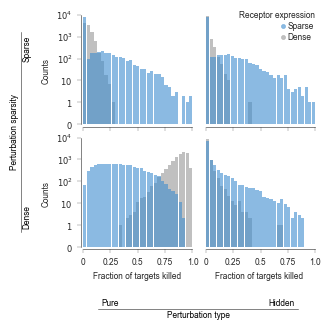

In [11]:
# SUPPLEMENTARY FIGURE WITH CONTINUOUS RECEPTOR EXPRESSION PROFILES -- NO SIGNIFICANT DIFFERENCE

N_SAMPLES = 10000  # number of target cells
N_CELLS   = 10000  # number of immune cells
BINOM_P   = 0.22   # binomial receptor expression probability

w       = SINGLE_COLUMN
hshrink = 1.0
goldh   = w * hshrink
fig     = plt.figure(figsize=(w, goldh))

box_top    = 0.95
box_bottom = 0.25
box_left   = 0.25
box_right  = 0.95

box_hist = dict(left=box_left, right=box_right, bottom=box_bottom, top=box_top)
gs_hist  = gridspec.GridSpec(2, 2, wspace=0.10, hspace=0.10, **box_hist)

psparsity = ['sparse', 'dense']
ptype = ['pure', 'hidden']
prof = 'continuous'
scale = 5
idx = 0

for i_idx in range(len(psparsity)):
    for j_idx in range(len(ptype)):
        data = np.load('%s/response_%s_%s_%s_%d_perturb_%d.npz' %
               (DATA_FOLDER, prof, psparsity[i_idx], ptype[j_idx], scale, idx))
        sparse_act = data['binom']
        dense_act  = data['uniform']

        sparse_n = np.array([np.sum(i)/N_SAMPLES for i in sparse_act])
        dense_n  = np.array([np.sum(i)/N_SAMPLES for i in  dense_act])

        p_max = 1
        n_bins = 31
        bin_dp = p_max / n_bins
        bins = np.arange(0, p_max+bin_dp, bin_dp)
        
        sparse_y = [np.sum((bins[i]<=sparse_n) & (sparse_n<bins[i+1])) for i in range(len(bins)-1)]
        sparse_y.append(np.sum(sparse_n>=bins[-1]))
        
        dense_y = [np.sum((bins[i]<=dense_n) & (dense_n<bins[i+1])) for i in range(len(bins)-1)]
        dense_y.append(np.sum(dense_n>=bins[-1]))
        
        for i in range(len(sparse_y)):
            if sparse_y[i]>0:
                sparse_y[i] = 1 + np.log10(sparse_y[i])
            else:
                sparse_y[i] = 0
                
        for i in range(len(dense_y)):
            if dense_y[i]>0:
                dense_y[i] = 1 + np.log10(dense_y[i])
            else:
                dense_y[i] = 0
                
        hist_props = dict(lw=AXWIDTH/2, width=0.9*p_max/n_bins, align='center', alpha=0.6,
                          orientation='vertical')#, edgecolor=[BKCOLOR])

        pprops = { 'xlim':        [0, p_max],
                   'xticks':      [ 0, 0.25, 0.5, 0.75, 1.0],
                   'xticklabels': ['',   '',  '',   '',  ''],
                   'ylim':        [0, 5],
                   'yticks':      [],
                   'colors':      [COLOR_ONE, LCOLOR],
                   'plotprops':   hist_props,
                   'axoffset':    0.1,
                   'theme':       'open',
                   'hide':        ['left'] }

        if j_idx==0:
            pprops['yticks']      = [0, 1, 2, 3, 4, 5]
            pprops['yticklabels'] = [r'$0$', r'$1$', r'$10$', r'$10^2$', r'$10^3$', r'$10^4$']
            pprops['ylabel']      = 'Counts'
            pprops['hide'].remove('left')

        if i_idx==1:
            pprops['xticklabels'] = [ 0, 0.25, 0.5, 0.75, 1.0]
            pprops['xlabel']      = 'Fraction of targets killed'

        ax = plt.subplot(gs_hist[i_idx, j_idx])
        mp.plot(type='bar', ax=ax, x=[bins+(bin_dp/2), bins+(bin_dp/2)], y=[sparse_y, dense_y], **pprops)
        
        # legend

        if i_idx==0 and j_idx==1:
            legend_x  =  0.75
            legend_d  = -0.04
            legend_y  = 4.5
            legend_dy = 0.5
            plotprops = dict(mew=AXWIDTH, markersize=SMALLSIZEDOT/2, fmt='o', elinewidth=SIZELINE/2, 
                             capthick=0, capsize=0, clip_on=False, alpha=0.6)

            ax.text(1.0, legend_y + legend_dy, 'Receptor expression', ha='right', va='center', **DEF_LABELPROPS)
            mp.error(ax=ax, x=[[legend_x + legend_d]], y=[[legend_y]], 
                     colors=[COLOR_ONE], plotprops=plotprops)
            ax.text(legend_x, legend_y, 'Sparse', ha='left', va='center', **DEF_LABELPROPS)
            mp.error(ax=ax, x=[[legend_x + legend_d]], y=[[legend_y - legend_dy]],
                     colors=[LCOLOR], plotprops=plotprops)
            ax.text(legend_x, legend_y - legend_dy, 'Dense', ha='left', va='center', **DEF_LABELPROPS)
                

lprops = dict(lw=AXWIDTH, ls='-', transform=fig.transFigure, clip_on=False)
xy = 0.07
dxy = 0.05
mp.line(ax=ax, x=[[xy, xy]], y=[[box_top-dxy, box_bottom+dxy]], colors=[BKCOLOR], plotprops=lprops)
mp.line(ax=ax, x=[[box_left+dxy, box_right-dxy]], y=[[xy, xy]], colors=[BKCOLOR], plotprops=lprops)
            
tprops = dict(family=FONTFAMILY, size=SIZELABEL, transform=fig.transFigure, clip_on=False)
ddxy = 0.005
ax.text(xy-ddxy, (box_top+box_bottom)/2, 'Perturbation sparsity', rotation=90, ha='right', va='center', **tprops)
ax.text(xy+ddxy, box_top-dxy-2*ddxy, 'Sparse', rotation=90, ha='left', va='top', **tprops)
ax.text(xy+ddxy, box_bottom+dxy+2*ddxy, 'Dense', rotation=90, ha='left', va='bottom', **tprops)
ax.text((box_left+box_right)/2, xy-ddxy, 'Perturbation type', rotation=0, ha='center', va='top', **tprops)
ax.text(box_left+dxy+2*ddxy, xy+ddxy, 'Pure', rotation=0, ha='left', va='bottom', **tprops)
ax.text(box_right-dxy-2*ddxy, xy+ddxy, 'Hidden', rotation=0, ha='right', va='bottom', **tprops)

            
# SAVE FIGURE

plt.savefig('figures/figs8-highdim-%s.pdf' % prof, dpi=1000, facecolor=fig.get_facecolor(), 
            edgecolor=None, **FIGPROPS)
plt.show()
plt.close(fig)

# New Figure 2

### Relationship between receptor expression and detection

sparse-pure
SignificanceResult(statistic=0.711899765002908, pvalue=0.0)
SignificanceResult(statistic=0.6117808386413118, pvalue=0.0)
sparse-hidden
SignificanceResult(statistic=0.8449151341088583, pvalue=0.0)
SignificanceResult(statistic=0.8192140601164992, pvalue=0.0)
dense-pure
SignificanceResult(statistic=0.8974200513735092, pvalue=0.0)
SignificanceResult(statistic=0.7308741529219815, pvalue=0.0)
dense-hidden
SignificanceResult(statistic=0.9714632191563985, pvalue=0.0)
SignificanceResult(statistic=0.9129567437598675, pvalue=0.0)


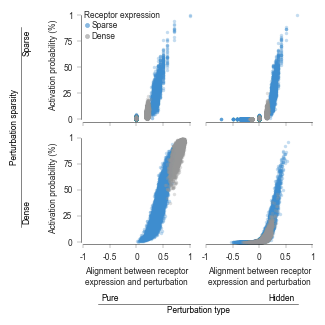

In [13]:
N_SAMPLES = 10000  # number of target cells
N_CELLS   = 10000  # number of immune cells
BINOM_P   = 0.22   # binomial receptor expression probability

D_ACT     = 10             # number of activating ligands
D_INH     = 22             # number of inhibitory ligands
D         = D_ACT + D_INH  # total number of ligands
INT_SIGNS = np.array([1 if i<D_ACT else -1 for i in range(D)])  # sign of interactions

# plot

w       = SINGLE_COLUMN
hshrink = 1.0
goldh   = w * hshrink
fig     = plt.figure(figsize=(w, goldh))

box_top    = 0.95
box_bottom = 0.25
box_left   = 0.25
box_right  = 0.95

box_hist = dict(left=box_left, right=box_right, bottom=box_bottom, top=box_top)
gs_hist  = gridspec.GridSpec(2, 2, wspace=0.10, hspace=0.10, **box_hist)

psparsity = ['sparse', 'dense']
ptype = ['pure', 'hidden']
prof = 'binary'
scale = 5
idx = 0

for i_idx in range(len(psparsity)):
    for j_idx in range(len(ptype)):
        data = np.load('%s/response_%s_%s_%s_%d_perturb_%d.npz' %
               (DATA_FOLDER, prof, psparsity[i_idx], ptype[j_idx], scale, idx))
        sparse_act = data['binom']
        dense_act  = data['uniform']

        sparse_n = np.array([np.sum(i)/N_SAMPLES for i in sparse_act])
        dense_n  = np.array([np.sum(i)/N_SAMPLES for i in  dense_act])
        
        # compute inner product with the perturbation

        perturb = np.load('%s/perturb_%s_%s.npy' % (DATA_FOLDER, psparsity[i_idx], ptype[j_idx]))

        sparse_profiles = np.load('%s/binom_profiles_%s.npy' % (DATA_FOLDER, prof))
        dense_profiles = np.load('%s/uniform_profiles_%s.npy' % (DATA_FOLDER, prof))

        sparse_ip = [np.dot(p, INT_SIGNS*perturb[idx])/np.sqrt(np.sum(p**2)*np.sum(perturb[idx]**2)) 
                      for p in sparse_profiles]
        dense_ip  = [np.dot(p, INT_SIGNS*perturb[idx])/np.sqrt(np.sum(p**2)*np.sum(perturb[idx]**2)) 
                      for p in dense_profiles]
        
        # show inner product versus response rate
        
        scatter_props = DEF_SCATTERPROPS.copy()
        scatter_props['alpha'] = 0.3

        pprops = { 'xlim':        [-1, 1.05],
                   'xticks':      [-1, -0.5, 0, 0.5, 1],
                   'xticklabels': ['', '', '', '', ''],
                   'ylim':        [0, 1.05],
                   'yticks':      [],
                   'colors':      [COLOR_ONE, LCOLOR],
                   'plotprops':   scatter_props,
                   'axoffset':    0.1,
                   'theme':       'open',
                   'hide':        ['left'] }

        if j_idx==0:
            pprops['yticks']      = [0, 0.25, 0.50, 0.75, 1]
            pprops['yticklabels'] = [0, 25, 50, 75, 1]
            pprops['ylabel']      = 'Activation probability (%)'
            pprops['hide'].remove('left')

        if i_idx==1:
            pprops['xticklabels'] = [-1, -0.5, 0, 0.5, 1]
            pprops['xlabel']      = 'Alignment between receptor\nexpression and perturbation'

        ax = plt.subplot(gs_hist[i_idx, j_idx])
        mp.plot(type='scatter', ax=ax, x=[sparse_ip, dense_ip], y=[sparse_n, dense_n], **pprops)

        # print statistics
        
        print('%s-%s' % (psparsity[i_idx], ptype[j_idx]))
        print(sp.stats.spearmanr(sparse_ip, sparse_n))
        print(sp.stats.spearmanr(dense_ip, dense_n))
        
        # legend

        if i_idx==0 and j_idx==0:
            legend_x  = -0.93
            legend_d  = -0.08
            legend_y  = 4.5/5
            legend_dy = 0.5/5
            plotprops = dict(mew=AXWIDTH, markersize=SMALLSIZEDOT/2, fmt='o', elinewidth=SIZELINE/2, 
                             capthick=0, capsize=0, clip_on=False, alpha=0.6)

            ax.text(-0.98, legend_y + legend_dy, 'Receptor expression', ha='left', va='center', **DEF_LABELPROPS)
            mp.error(ax=ax, x=[[legend_x]], y=[[legend_y]], 
                     colors=[COLOR_ONE], plotprops=plotprops)
            ax.text(legend_x - legend_d, legend_y, 'Sparse', ha='left', va='center', **DEF_LABELPROPS)
            mp.error(ax=ax, x=[[legend_x]], y=[[legend_y - legend_dy]],
                     colors=[LCOLOR], plotprops=plotprops)
            ax.text(legend_x - legend_d, legend_y - legend_dy, 'Dense', ha='left', va='center', **DEF_LABELPROPS)
                

lprops = dict(lw=AXWIDTH, ls='-', transform=fig.transFigure, clip_on=False)
xy = 0.07
dxy = 0.05
mp.line(ax=ax, x=[[xy, xy]], y=[[box_top-dxy, box_bottom+dxy]], colors=[BKCOLOR], plotprops=lprops)
mp.line(ax=ax, x=[[box_left+dxy, box_right-dxy]], y=[[xy, xy]], colors=[BKCOLOR], plotprops=lprops)
            
tprops = dict(family=FONTFAMILY, size=SIZELABEL, transform=fig.transFigure, clip_on=False)
ddxy = 0.005
ax.text(xy-ddxy, (box_top+box_bottom)/2, 'Perturbation sparsity', rotation=90, ha='right', va='center', **tprops)
ax.text(xy+ddxy, box_top-dxy-2*ddxy, 'Sparse', rotation=90, ha='left', va='top', **tprops)
ax.text(xy+ddxy, box_bottom+dxy+2*ddxy, 'Dense', rotation=90, ha='left', va='bottom', **tprops)
ax.text((box_left+box_right)/2, xy-ddxy, 'Perturbation type', rotation=0, ha='center', va='top', **tprops)
ax.text(box_left+dxy+2*ddxy, xy+ddxy, 'Pure', rotation=0, ha='left', va='bottom', **tprops)
ax.text(box_right-dxy-2*ddxy, xy+ddxy, 'Hidden', rotation=0, ha='right', va='bottom', **tprops)

            
# SAVE FIGURE

plt.savefig('figures/fig6-correlation-%s.pdf' % prof, 
            dpi=1000, facecolor=fig.get_facecolor(), edgecolor=None, **FIGPROPS)
plt.show()
plt.close(fig)

sparse-pure
SignificanceResult(statistic=0.7219141372312671, pvalue=0.0)
SignificanceResult(statistic=0.7968492413413613, pvalue=0.0)
sparse-hidden
SignificanceResult(statistic=0.8490157369901695, pvalue=0.0)
SignificanceResult(statistic=0.9032267962190006, pvalue=0.0)
dense-pure
SignificanceResult(statistic=0.8983643628176947, pvalue=0.0)
SignificanceResult(statistic=0.74615328275499, pvalue=0.0)
dense-hidden
SignificanceResult(statistic=0.971437207220072, pvalue=0.0)
SignificanceResult(statistic=0.9193354042254562, pvalue=0.0)


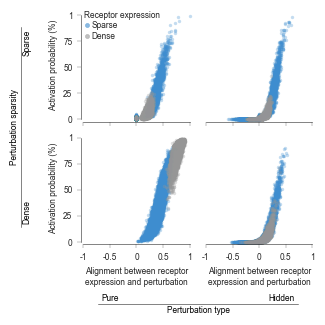

In [14]:
N_SAMPLES = 10000  # number of target cells
N_CELLS   = 10000  # number of immune cells
BINOM_P   = 0.22   # binomial receptor expression probability

D_ACT     = 10             # number of activating ligands
D_INH     = 22             # number of inhibitory ligands
D         = D_ACT + D_INH  # total number of ligands
INT_SIGNS = np.array([1 if i<D_ACT else -1 for i in range(D)])  # sign of interactions

# plot

w       = SINGLE_COLUMN
hshrink = 1.0
goldh   = w * hshrink
fig     = plt.figure(figsize=(w, goldh))

box_top    = 0.95
box_bottom = 0.25
box_left   = 0.25
box_right  = 0.95

box_hist = dict(left=box_left, right=box_right, bottom=box_bottom, top=box_top)
gs_hist  = gridspec.GridSpec(2, 2, wspace=0.10, hspace=0.10, **box_hist)

psparsity = ['sparse', 'dense']
ptype = ['pure', 'hidden']
prof = 'continuous'
scale = 5
idx = 0

for i_idx in range(len(psparsity)):
    for j_idx in range(len(ptype)):
        data = np.load('%s/response_%s_%s_%s_%d_perturb_%d.npz' %
               (DATA_FOLDER, prof, psparsity[i_idx], ptype[j_idx], scale, idx))
        sparse_act = data['binom']
        dense_act  = data['uniform']

        sparse_n = np.array([np.sum(i)/N_SAMPLES for i in sparse_act])
        dense_n  = np.array([np.sum(i)/N_SAMPLES for i in  dense_act])
        
        # compute inner product with the perturbation

        perturb = np.load('%s/perturb_%s_%s.npy' % (DATA_FOLDER, psparsity[i_idx], ptype[j_idx]))

        sparse_profiles = np.load('%s/binom_profiles_%s.npy' % (DATA_FOLDER, prof))
        dense_profiles = np.load('%s/uniform_profiles_%s.npy' % (DATA_FOLDER, prof))

        sparse_ip = [np.dot(p, INT_SIGNS*perturb[idx])/np.sqrt(np.sum(p**2)*np.sum(perturb[idx]**2)) 
                      for p in sparse_profiles]
        dense_ip  = [np.dot(p, INT_SIGNS*perturb[idx])/np.sqrt(np.sum(p**2)*np.sum(perturb[idx]**2)) 
                      for p in dense_profiles]
        
        # show inner product versus response rate
        
        scatter_props = DEF_SCATTERPROPS.copy()
        scatter_props['alpha'] = 0.3

        pprops = { 'xlim':        [-1, 1.05],
                   'xticks':      [-1, -0.5, 0, 0.5, 1],
                   'xticklabels': ['', '', '', '', ''],
                   'ylim':        [0, 1.05],
                   'yticks':      [],
                   'colors':      [COLOR_ONE, LCOLOR],
                   'plotprops':   scatter_props,
                   'axoffset':    0.1,
                   'theme':       'open',
                   'hide':        ['left'] }

        if j_idx==0:
            pprops['yticks']      = [0, 0.25, 0.50, 0.75, 1]
            pprops['yticklabels'] = [0, 25, 50, 75, 1]
            pprops['ylabel']      = 'Activation probability (%)'
            pprops['hide'].remove('left')

        if i_idx==1:
            pprops['xticklabels'] = [-1, -0.5, 0, 0.5, 1]
            pprops['xlabel']      = 'Alignment between receptor\nexpression and perturbation'

        ax = plt.subplot(gs_hist[i_idx, j_idx])
        mp.plot(type='scatter', ax=ax, x=[sparse_ip, dense_ip], y=[sparse_n, dense_n], **pprops)

        # print statistics
        
        print('%s-%s' % (psparsity[i_idx], ptype[j_idx]))
        print(sp.stats.spearmanr(sparse_ip, sparse_n))
        print(sp.stats.spearmanr(dense_ip, dense_n))
        
        # legend

        if i_idx==0 and j_idx==0:
            legend_x  = -0.93
            legend_d  = -0.08
            legend_y  = 4.5/5
            legend_dy = 0.5/5
            plotprops = dict(mew=AXWIDTH, markersize=SMALLSIZEDOT/2, fmt='o', elinewidth=SIZELINE/2, 
                             capthick=0, capsize=0, clip_on=False, alpha=0.6)

            ax.text(-0.98, legend_y + legend_dy, 'Receptor expression', ha='left', va='center', **DEF_LABELPROPS)
            mp.error(ax=ax, x=[[legend_x]], y=[[legend_y]], 
                     colors=[COLOR_ONE], plotprops=plotprops)
            ax.text(legend_x - legend_d, legend_y, 'Sparse', ha='left', va='center', **DEF_LABELPROPS)
            mp.error(ax=ax, x=[[legend_x]], y=[[legend_y - legend_dy]],
                     colors=[LCOLOR], plotprops=plotprops)
            ax.text(legend_x - legend_d, legend_y - legend_dy, 'Dense', ha='left', va='center', **DEF_LABELPROPS)
                

lprops = dict(lw=AXWIDTH, ls='-', transform=fig.transFigure, clip_on=False)
xy = 0.07
dxy = 0.05
mp.line(ax=ax, x=[[xy, xy]], y=[[box_top-dxy, box_bottom+dxy]], colors=[BKCOLOR], plotprops=lprops)
mp.line(ax=ax, x=[[box_left+dxy, box_right-dxy]], y=[[xy, xy]], colors=[BKCOLOR], plotprops=lprops)
            
tprops = dict(family=FONTFAMILY, size=SIZELABEL, transform=fig.transFigure, clip_on=False)
ddxy = 0.005
ax.text(xy-ddxy, (box_top+box_bottom)/2, 'Perturbation sparsity', rotation=90, ha='right', va='center', **tprops)
ax.text(xy+ddxy, box_top-dxy-2*ddxy, 'Sparse', rotation=90, ha='left', va='top', **tprops)
ax.text(xy+ddxy, box_bottom+dxy+2*ddxy, 'Dense', rotation=90, ha='left', va='bottom', **tprops)
ax.text((box_left+box_right)/2, xy-ddxy, 'Perturbation type', rotation=0, ha='center', va='top', **tprops)
ax.text(box_left+dxy+2*ddxy, xy+ddxy, 'Pure', rotation=0, ha='left', va='bottom', **tprops)
ax.text(box_right-dxy-2*ddxy, xy+ddxy, 'Hidden', rotation=0, ha='right', va='bottom', **tprops)

            
# SAVE FIGURE

plt.savefig('figures/figs9-correlation-%s.pdf' % prof, 
            dpi=1000, facecolor=fig.get_facecolor(), edgecolor=None, **FIGPROPS)
plt.show()
plt.close(fig)

sparse-pure
SignificanceResult(statistic=0.7236597129346733, pvalue=0.0)
SignificanceResult(statistic=0.8062832656326558, pvalue=0.0)
sparse-hidden
SignificanceResult(statistic=0.7014492760842476, pvalue=0.0)
SignificanceResult(statistic=0.7454726816961973, pvalue=0.0)


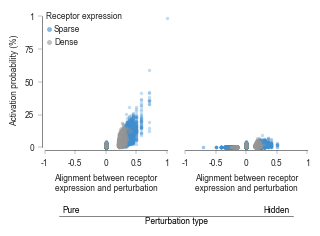

In [23]:
DATA_FOLDER = 'data-threshold/'

N_SAMPLES = 10000  # number of target cells
N_CELLS   = 10000  # number of immune cells
BINOM_P   = 0.22   # binomial receptor expression probability

D_ACT     = 10             # number of activating ligands
D_INH     = 22             # number of inhibitory ligands
D         = D_ACT + D_INH  # total number of ligands
INT_SIGNS = np.array([1 if i<D_ACT else -1 for i in range(D)])  # sign of interactions

# plot

w       = SINGLE_COLUMN
hshrink = 0.7
goldh   = w * hshrink
fig     = plt.figure(figsize=(w, goldh))

box_top    = 0.95
box_bottom = 0.35
box_left   = 0.15
box_right  = 0.95

box_hist = dict(left=box_left, right=box_right, bottom=box_bottom, top=box_top)
gs_hist  = gridspec.GridSpec(1, 2, wspace=0.10, hspace=0.10, **box_hist)

psparsity = ['sparse']
ptype = ['pure', 'hidden']
prof = 'binary'
scale = 5
idx = 0

for i_idx in range(len(psparsity)):
    for j_idx in range(len(ptype)):
        data = np.load('%s/response_%s_%s_%s_%d_perturb_%d.npz' %
               (DATA_FOLDER, prof, psparsity[i_idx], ptype[j_idx], scale, idx))
        sparse_act = data['binom']
        dense_act  = data['uniform']

        sparse_n = np.array([np.sum(i)/N_SAMPLES for i in sparse_act])
        dense_n  = np.array([np.sum(i)/N_SAMPLES for i in  dense_act])
        
        # compute inner product with the perturbation

        perturb = np.load('%s/perturb_%s_%s.npy' % (DATA_FOLDER, psparsity[i_idx], ptype[j_idx]))

        sparse_profiles = np.load('%s/binom_profiles_%s.npy' % (DATA_FOLDER, prof))
        dense_profiles = np.load('%s/uniform_profiles_%s.npy' % (DATA_FOLDER, prof))

        sparse_ip = [np.dot(p, INT_SIGNS*perturb[idx])/np.sqrt(np.sum(p**2)*np.sum(perturb[idx]**2)) 
                      for p in sparse_profiles]
        dense_ip  = [np.dot(p, INT_SIGNS*perturb[idx])/np.sqrt(np.sum(p**2)*np.sum(perturb[idx]**2)) 
                      for p in dense_profiles]
        
        # show inner product versus response rate
        
        scatter_props = DEF_SCATTERPROPS.copy()
        scatter_props['alpha'] = 0.3

        pprops = { 'xlim':        [-1, 1.05],
                   'xticks':      [-1, -0.5, 0, 0.5, 1],
                   'xticklabels': ['', '', '', '', ''],
                   'ylim':        [0, 1.05],
                   'yticks':      [],
                   'colors':      [COLOR_ONE, LCOLOR],
                   'plotprops':   scatter_props,
                   'axoffset':    0.1,
                   'theme':       'open',
                   'hide':        ['left'] }

        if j_idx==0:
            pprops['yticks']      = [0, 0.25, 0.50, 0.75, 1]
            pprops['yticklabels'] = [0, 25, 50, 75, 1]
            pprops['ylabel']      = 'Activation probability (%)'
            pprops['hide'].remove('left')

        if i_idx==0:
            pprops['xticklabels'] = [-1, -0.5, 0, 0.5, 1]
            pprops['xlabel']      = 'Alignment between receptor\nexpression and perturbation'

        ax = plt.subplot(gs_hist[i_idx, j_idx])
        mp.plot(type='scatter', ax=ax, x=[sparse_ip, dense_ip], y=[sparse_n, dense_n], **pprops)

        # print statistics
        
        print('%s-%s' % (psparsity[i_idx], ptype[j_idx]))
        print(sp.stats.spearmanr(sparse_ip, sparse_n))
        print(sp.stats.spearmanr(dense_ip, dense_n))
        
        # legend

        if i_idx==0 and j_idx==0:
            legend_x  = -0.93
            legend_d  = -0.08
            legend_y  = 4.5/5
            legend_dy = 0.5/5
            plotprops = dict(mew=AXWIDTH, markersize=SMALLSIZEDOT/2, fmt='o', elinewidth=SIZELINE/2, 
                             capthick=0, capsize=0, clip_on=False, alpha=0.6)

            ax.text(-0.98, legend_y + legend_dy, 'Receptor expression', ha='left', va='center', **DEF_LABELPROPS)
            mp.error(ax=ax, x=[[legend_x]], y=[[legend_y]], 
                     colors=[COLOR_ONE], plotprops=plotprops)
            ax.text(legend_x - legend_d, legend_y, 'Sparse', ha='left', va='center', **DEF_LABELPROPS)
            mp.error(ax=ax, x=[[legend_x]], y=[[legend_y - legend_dy]],
                     colors=[LCOLOR], plotprops=plotprops)
            ax.text(legend_x - legend_d, legend_y - legend_dy, 'Dense', ha='left', va='center', **DEF_LABELPROPS)
                

lprops = dict(lw=AXWIDTH, ls='-', transform=fig.transFigure, clip_on=False)
xy = 0.07
dxy = 0.05
# mp.line(ax=ax, x=[[xy, xy]], y=[[box_top-dxy, box_bottom+dxy]], colors=[BKCOLOR], plotprops=lprops)
mp.line(ax=ax, x=[[box_left+dxy, box_right-dxy]], y=[[xy, xy]], colors=[BKCOLOR], plotprops=lprops)
            
tprops = dict(family=FONTFAMILY, size=SIZELABEL, transform=fig.transFigure, clip_on=False)
ddxy = 0.005
# ax.text(xy-ddxy, (box_top+box_bottom)/2, 'Perturbation sparsity', rotation=90, ha='right', va='center', **tprops)
# ax.text(xy+ddxy, box_top-dxy-2*ddxy, 'Sparse', rotation=90, ha='left', va='top', **tprops)
# ax.text(xy+ddxy, box_bottom+dxy+2*ddxy, 'Dense', rotation=90, ha='left', va='bottom', **tprops)
ax.text((box_left+box_right)/2, xy-ddxy, 'Perturbation type', rotation=0, ha='center', va='top', **tprops)
ax.text(box_left+dxy+2*ddxy, xy+ddxy, 'Pure', rotation=0, ha='left', va='bottom', **tprops)
ax.text(box_right-dxy-2*ddxy, xy+ddxy, 'Hidden', rotation=0, ha='right', va='bottom', **tprops)

            
# SAVE FIGURE

plt.savefig('receptor-perturbation-correlations-threshold-%s.pdf' % prof, 
            dpi=1000, facecolor=fig.get_facecolor(), edgecolor=None, **FIGPROPS)
plt.show()
plt.close(fig)


DATA_FOLDER = 'data/'

# Figure 4. Fitting the model to experimental data

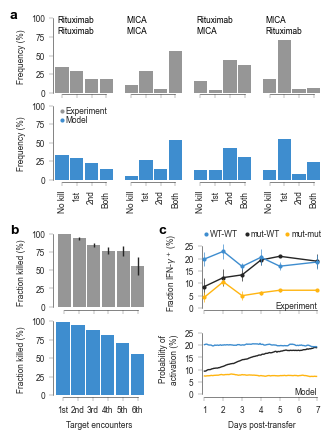

In [24]:
# FIGURE PROPERTIES

w       = SINGLE_COLUMN
hshrink = 1.3
goldh   = w * hshrink
fig     = plt.figure(figsize=(w, goldh))

box_left   = 0.15
box_right  = 0.95
box_top    = 0.97
box_bottom = 0.10

dx = 0.17
x  = (box_right - box_left - 1*dx)/2.3

dy = dx / (hshrink * (box_top - box_bottom) / (box_right - box_left))
y  = (box_top - box_bottom - 1*dy)/2


# box_a = dict(left=box_left, right=box_right, top=box_top,          bottom=box_top-1*y)
# box_b = dict(left=box_left, right=0.55,      top=box_top-1*y-1*dy, bottom=box_top-2*y-1*dy)
# box_c = dict(left=box_left, right=box_right, top=box_top-2*y-2*dy, bottom=box_top-3*y-2*dy)

# gs_a  = gridspec.GridSpec(1, 4, wspace=0.10, hspace=0.10, **box_a)
# gs_b  = gridspec.GridSpec(1, 2, wspace=0.10, hspace=0.10, **box_b)
# gs_c  = gridspec.GridSpec(1, 1, wspace=0.10, hspace=0.10, **box_c)

box_a = dict(left=box_left,      right=box_right,  top=box_top,          bottom=box_top-1*y)
box_b = dict(left=box_left,      right=box_left+x, top=box_top-1*y-1*dy, bottom=box_top-2*y-1*dy)
box_c = dict(left=box_left+x+dx, right=box_right,  top=box_top-1*y-1*dy, bottom=box_top-2*y-1*dy)

gs_a  = gridspec.GridSpec(2, 4, wspace=0.15, hspace=0.15, **box_a)
gs_b  = gridspec.GridSpec(2, 1, wspace=0.15, hspace=0.15, **box_b)
gs_c  = gridspec.GridSpec(2, 1, wspace=0.15, hspace=0.15, **box_c)

# PANEL A: SRPAN ET AL

# update the mean and std
def training(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=0, signal_std=1):
    betac1 = (alpha-1)/(alpha-0.5)
    betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
    for nstep in range(int(np.round(num_encounter))):
        xs = signal_mean+signal_std*np.random.randn(n_cells)  # gauss(mean,std)
        ms_new = (kappa*ms_est+xs)/(kappa+1)
        betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
        ms_est = ms_new
        beta_est = betas_new
    return(ms_est, beta_est)

def killing(alpha, kappa, n_cells, ms_est, beta_est, mu_1, sigma_1, mu_2, sigma_2):
    betac1 = (alpha-1)/(alpha-0.5)
    betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
    res_rr = np.zeros((n_cells,2))
    xs = np.random.randn(n_cells) * sigma_1 + mu_1
    for i in range(n_cells):
        threshold = sp.stats.t.ppf(1-theta, 2*alpha, ms_est[i], np.sqrt((kappa+1)*beta_est[i]/kappa/alpha))
        if threshold < xs[i]:
            res_rr[i,0] = 1
    ms_new = (kappa*ms_est+xs)/(kappa+1)
    betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
    xs = np.random.randn(n_cells) * sigma_2 + mu_2
    for i in range(n_cells):
        threshold = sp.stats.t.ppf(1-theta, 2*alpha, ms_new[i], np.sqrt((kappa+1)*betas_new[i]/kappa/alpha))
        if threshold < xs[i]:
            res_rr[i,1] = 1
    # stat
    rr00=0
    rr10=0
    rr01=0
    rr11=0
    for i in range(n_cells):
        if res_rr[i,0]==0 and res_rr[i,1]==0:
            rr00+=1
        elif res_rr[i,0]==1 and res_rr[i,1]==0:
            rr10+=1
        elif res_rr[i,0]==0 and res_rr[i,1]==1:
            rr01+=1
        elif res_rr[i,0]==1 and res_rr[i,1]==1:
            rr11+=1
    rr = np.array([rr00,rr10,rr01,rr11])/n_cells*100
    return(rr)


# experiment

rr_e = np.array([0.345, 0.285, 0.18, 0.19])*100
mm_e = np.array([0.1, 0.285, 0.055, 0.56])*100
rm_e = np.array([0.16, 0.03, 0.44, 0.37])*100
mr_e = np.array([0.18, 0.71, 0.05, 0.06])*100

# model 

theta = 0.01
alpha = 21.5
kappa = 2*alpha
num_encounter = 50*alpha
n_cells = 10000

mu_r = 2.2
sigma_r = 1
mu_m = 3.2
sigma_m = 1

ms_est = np.zeros(n_cells)
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = training(ms_est, beta_est, alpha, kappa, num_encounter) 

rr_m = killing(alpha, kappa, n_cells, ms_est, beta_est, mu_r, sigma_r, mu_r, sigma_r)
rm_m = killing(alpha, kappa, n_cells, ms_est, beta_est, mu_r, sigma_r, mu_m, sigma_m)
mm_m = killing(alpha, kappa, n_cells, ms_est, beta_est, mu_m, sigma_m, mu_m, sigma_m)
mr_m = killing(alpha, kappa, n_cells, ms_est, beta_est, mu_m, sigma_m, mu_r, sigma_r)

# plotting

nps = 4
axs = [[plt.subplot(gs_a[i, j]) for j in range(nps)] for i in range(2)]

colors  = [LCOLOR, COLOR_ONE]
values  = [[rr_e, mm_e, rm_e, mr_e], [rr_m, mm_m, rm_m, mr_m]]
xlabels = ['No kill', '1st', '2nd', 'Both']
plabels = ['Rituximab\nRituximab', 'MICA\nMICA', 'Rituximab\nMICA', 'MICA\nRituximab']

for i in range(2):
    for j in range(nps):
        
        txt_props = dict(family=FONTFAMILY, size=SIZELABEL, clip_on=False)
        bar_props = dict(lw=0, width=0.9, align='center', orientation='vertical')
        
        pprops = { 'xlim':        [-0.5, 3.5],
                   'xticks':      [0, 1, 2, 3],
                   'xticklabels': xlabels,
                   'ylim':        [0, 100],
                   'yticks':      [],
                   'colors':      [colors[i]],
                   'plotprops':   bar_props,
                   'axoffset':    0.1,
                   'theme':       'open',
                   'hide':        ['left'] }
        
        if i==0:
            axs[i][j].text(-0.30, 80, plabels[j], **txt_props)
            pprops['xticklabels'] = ['' for k in range(nps)]
        if j==0:
            pprops['yticks'] = [0, 25, 50, 75, 100]
            pprops['ylabel'] = 'Frequency (%)'
            pprops['hide'].remove('left')
            
        mp.plot(type='bar', ax=axs[i][j], x=[range(nps)], y=[values[i][j]], **pprops)
        
        if i==1:
            axs[i][j].tick_params(axis='x', labelrotation=90)
            
        # legend

        if i==1 and j==0:
            legend_x  = 0.25
            legend_d  = -0.25
            legend_y  = 93
            legend_dy = 12
            plotprops = dict(mew=0, markersize=SMALLSIZEDOT/2, fmt='o', elinewidth=SIZELINE/2, 
                             capthick=0, capsize=0, clip_on=False)

            mp.error(ax=axs[i][j], x=[[legend_x + legend_d]], y=[[legend_y]], 
                     colors=[LCOLOR], plotprops=plotprops)
            axs[i][j].text(legend_x, legend_y, 'Experiment', ha='left', va='center', **DEF_LABELPROPS)
            mp.error(ax=axs[i][j], x=[[legend_x + legend_d]], y=[[legend_y - legend_dy]],
                     colors=[COLOR_ONE], plotprops=plotprops)
            axs[i][j].text(legend_x, legend_y - legend_dy, 'Model', ha='left', va='center', **DEF_LABELPROPS)


# PANEL B: PRAGER ET AL

def initial_parameters(alpha, N):
    # update m=300 steps, healthy signal N(0,1)
    n_updates = 300
    kappa = 2*alpha
    ms = np.zeros(N)
    betas = np.ones(N)*alpha
    for j in range(n_updates):
        xs = np.random.randn(N)
        ms_new = (xs+kappa*ms)/(kappa+1)
        betas_new = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
        ms = ms_new
        betas = betas_new
    return (ms, betas)

def serial_kill(alpha, mu_t, sigma_t):
    N = 1000 # number of cells
    kappa = 2*alpha
    m, beta = initial_parameters(alpha, N)
    p = np.zeros(6)
    for i_encounter in range(6):
        threshold = sp.stats.t.ppf(0.99, 2*alpha, m, np.sqrt((kappa+1)*beta/kappa/alpha))
        x_rand = np.random.normal(mu_t,sigma_t,N)
        k = x_rand>threshold
        pk = 0
        for j in range(N):
            if k[j]==True:
                pk += 1
        pk = pk/N
        p[i_encounter] = pk
        mnew = (kappa*m+x_rand)/(kappa+1)
        betanew = (alpha-1)/(alpha-0.5)*(beta+0.5*kappa/(kappa+1)*(m-x_rand)**2)
        m = mnew
        beta = betanew
    return(p)

# experiment

n = np.array([347, 250, 151, 77, 38, 16])
y_e = np.array([0.997, 0.936, 0.848, 0.766, 0.763, 0.563])*100
x_e = np.array([1, 2, 3, 4, 5, 6])
y_e_std = np.sqrt(y_e/100*(1-y_e/100))
y_e_bar = y_e_std*100/np.sqrt(n)

# model

alpha, mu, sigma = 25.25, 4.65, 1
y_m = serial_kill(alpha, mu, sigma)*100
x_m = np.array([1, 2, 3, 4, 5, 6])

# plotting

axs = [plt.subplot(gs_b[i, 0]) for i in range(2)]

bar_props = dict(lw=0, width=0.9, align='center', orientation='vertical')

xlabels = ['1st', '2nd', '3rd', '4th', '5th', '6th']
        
pprops = { 'xlim':        [0.5, 6.5],
           'xticks':      [1, 2, 3, 4, 5, 6],
           'xticklabels': xlabels,
           'ylim':        [0, 100],
           'yticks':      [0, 25, 50, 75, 100],
           'ylabel':      'Fraction killed (%)',
           'plotprops':   bar_props,
           'axoffset':    0.1,
           'theme':       'open' }

pprops['colors'] = [COLOR_ONE]
pprops['xlabel'] = 'Target encounters'
mp.plot(type='bar', ax=axs[1], x=[x_m], y=[y_m], **pprops)

pprops['colors'] = [LCOLOR]
pprops['xticklabels'] = ['', '', '', '', '', '']
del pprops['xlabel']
mp.plot(type='bar', ax=axs[0], x=[x_e], y=[y_e], yerr=[y_e_bar], **pprops)


# PANEL C: ELLIOTT ET AL

# update the mean and std
def update(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=0, signal_std=1):
    betac1 = (alpha-1)/(alpha-0.5)
    betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
    for nstep in range(int(np.round(num_encounter))):
        xs = signal_mean+signal_std*np.random.randn(n_cells)  # gauss(mean,std)
        ms_new = (kappa*ms_est+xs)/(kappa+1)
        betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
        ms_est = ms_new
        beta_est = betas_new
    return ms_est, beta_est

# calculate the probability of activation
def POA(alpha, kappa, ms_est, beta_est, u_target, std_target, signal_mean=0, signal_std=1):
    n_updates = 150
    n_cells = len(ms_est)
    theta = 0.01
    betac1 = (alpha-1)/(alpha-0.5)
    betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
    poa_mean = []
    for i in range(n_updates):
        threshold = []
        poa = []
        for i in range(n_cells):
            threshold.append(sp.stats.t.ppf(1-theta, 2*alpha, ms_est[i], np.sqrt((kappa+1)*beta_est[i]/kappa/alpha)))
            poa.append(1-sp.stats.norm.cdf(threshold[-1], loc=u_target, scale=std_target))
        poa_mean.append(np.mean(poa))
        # update
        xs = signal_mean+signal_std*np.random.randn(n_cells) 
        ms_new = (kappa*ms_est+xs)/(kappa+1)
        betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
        ms_est = ms_new
        beta_est = betas_new
    return poa_mean

# model

# WT blue line N(0,1), target N(0.9, 1.78)  
mu_a = 1.49
std_a = 1

mu_d = 0.59
std_d = 1

# constants
alpha = 20
kappa = 2*alpha

#initial encounters
num_encounter = 50*alpha
n_cells = 100

# WT -- WT
ms_est = np.zeros(n_cells)
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = update(ms_est, beta_est, alpha, kappa, num_encounter) 
model_wt_wt = POA(alpha, kappa, ms_est, beta_est, mu_a, std_a, signal_mean=0)

# mut -- mut
ms_est = np.ones(n_cells)*mu_d
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = update(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=mu_d) 
model_mut_mut = POA(alpha, kappa, ms_est, beta_est, mu_a, std_a, signal_mean=mu_d)

# mut -- WT
ms_est = np.ones(n_cells)*mu_d
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = update(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=mu_d) 
model_mut_wt = POA(alpha, kappa, ms_est, beta_est, mu_a, std_a, signal_mean=0)

# experiment

exp_wt_wt       = np.array([19.8, 22.9, 16.8, 20.5, 16.9, 18.6])/100
exp_wt_wt_err   = np.array([2.7, 2.9, 1.3, 3.3, 1.6, 2.8])/100
exp_mut_mut     = np.array([4.4, 10.6, 5, 6.2, 7.2, 7.2])/100
exp_mut_mut_err = np.array([2, 1.1, 1.9, 0.8, 0.7, 0.4])/100
exp_mut_wt      = np.array([8.7, 12.3, 13.4, 19.4, 20.9, 18.9])/100
exp_mut_wt_err  = np.array([3.6, 3.3, 2.6, 2.0, 0.3, 2.9])/100

# plotting

axs = [plt.subplot(gs_c[i, 0]) for i in range(2)]

pprops = { 'ylim':        [0, 0.30],
           'yticks':      [0, 0.05, 0.10, 0.15, 0.20, 0.25],
           'yticklabels': [0, 5, 10, 15, 20, 25],
           'colors':      [COLOR_ONE, COLOR_TWO, BKCOLOR],
           'axoffset':    0.1,
           'theme':       'open' }

err_props = DEF_ERRORPROPS.copy()
err_props['lw'] = SIZELINE
pprops['plotprops'] = err_props
pprops['xlim'] = [1, 7.2]
pprops['xticks'] = [1, 2, 3, 4, 5, 6, 7]
pprops['xticklabels'] = ['', '', '', '', '', '', '']
pprops['ylabel'] = r'Fraction IFN-$\gamma^+$ (%)'

x = np.array([1, 2, 3, 4, 5, 7])
mp.plot(type='error', ax=axs[0], x=[x, x, x], y=[exp_wt_wt, exp_mut_mut, exp_mut_wt], 
        yerr=[exp_wt_wt_err, exp_mut_mut_err, exp_mut_wt_err], **pprops)

line_props = DEF_LINEPROPS.copy()
pprops['plotprops'] = line_props
mp.line(ax=axs[0], x=[x, x, x], y=[exp_wt_wt, exp_mut_mut, exp_mut_wt], **pprops)

pprops['xlim'] = [20, 144]
pprops['xticks'] = [20, 40, 60, 80, 100, 120, 140]
pprops['xticklabels'] = [1, 2, 3, 4, 5, 6, 7]
pprops['xlabel'] = 'Days post-transfer'
pprops['ylabel'] = 'Probability of\nactivation (%)'
           
start = 20
x = np.array(range(start, 140))

mp.plot(type='line', ax=axs[1], x=[x, x, x], 
        y=[model_wt_wt[start:-10], model_mut_mut[start:-10], model_mut_wt[start:-10]], **pprops)

# legend

legend_x  = 1.3
legend_dx = 2.15
legend_d  = -0.20
legend_y  = 0.30
legend_dy = 0.05
plotprops = dict(mew=0, markersize=SMALLSIZEDOT/2, fmt='o', elinewidth=SIZELINE/2, 
                 capthick=0, capsize=0, clip_on=False)

mp.error(ax=axs[0], x=[[legend_x + legend_d]], y=[[legend_y]], colors=[COLOR_ONE], plotprops=plotprops)
axs[0].text(legend_x, legend_y, 'WT-WT', ha='left', va='center', **DEF_LABELPROPS)
mp.error(ax=axs[0], x=[[legend_x + legend_d + 1*legend_dx]], y=[[legend_y]], colors=[BKCOLOR], plotprops=plotprops)
axs[0].text(legend_x + 1*legend_dx, legend_y, 'mut-WT', ha='left', va='center', **DEF_LABELPROPS)
mp.error(ax=axs[0], x=[[legend_x + legend_d + 2*legend_dx]], y=[[legend_y]], colors=[COLOR_TWO], plotprops=plotprops)
axs[0].text(legend_x + 2*legend_dx, legend_y, 'mut-mut', ha='left', va='center', **DEF_LABELPROPS)

axs[0].text(  7, 0.01, 'Experiment', ha='right', va='center', **DEF_LABELPROPS)
axs[1].text(140, 0.01, 'Model', ha='right', va='center', **DEF_LABELPROPS)


# SUBLABELS

dx = 0.13
dy = 0
fig.text(box_a['left']-dx, box_a['top']-dy, string.ascii_uppercase[0].lower(), size=SUBLABEL_SIZE, weight='bold')
fig.text(box_b['left']-dx, box_b['top']-dy, string.ascii_uppercase[1].lower(), size=SUBLABEL_SIZE, weight='bold')
fig.text(box_c['left']-dx, box_c['top']-dy, string.ascii_uppercase[2].lower(), size=SUBLABEL_SIZE, weight='bold')

# SAVE FIGURE
            
plt.savefig('figures/fig4-fitting-experiment.pdf', dpi=1000, facecolor=fig.get_facecolor(), 
            edgecolor=None, **FIGPROPS)
plt.show()
plt.close(fig)

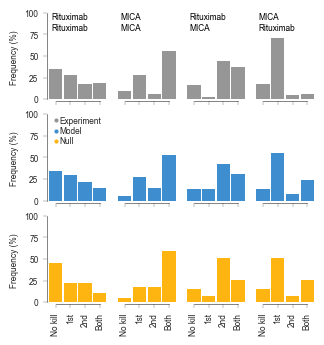

In [8]:
# FIGURE PROPERTIES

w       = SINGLE_COLUMN
hshrink = 1.0
goldh   = w * hshrink
fig     = plt.figure(figsize=(w, goldh))

box_left   = 0.15
box_right  = 0.95
box_top    = 0.97
box_bottom = 0.10

dx = 0.17
x  = (box_right - box_left - 1*dx)/2.3

dy = dx / (hshrink * (box_top - box_bottom) / (box_right - box_left))
y  = (box_top - box_bottom - 1*dy)/2


# box_a = dict(left=box_left, right=box_right, top=box_top,          bottom=box_top-1*y)
# box_b = dict(left=box_left, right=0.55,      top=box_top-1*y-1*dy, bottom=box_top-2*y-1*dy)
# box_c = dict(left=box_left, right=box_right, top=box_top-2*y-2*dy, bottom=box_top-3*y-2*dy)

# gs_a  = gridspec.GridSpec(1, 4, wspace=0.10, hspace=0.10, **box_a)
# gs_b  = gridspec.GridSpec(1, 2, wspace=0.10, hspace=0.10, **box_b)
# gs_c  = gridspec.GridSpec(1, 1, wspace=0.10, hspace=0.10, **box_c)

box_a = dict(left=box_left, right=box_right, top=box_top, bottom=box_bottom)
gs_a  = gridspec.GridSpec(3, 4, wspace=0.15, hspace=0.15, **box_a)

# PANEL A: SRPAN ET AL

# update the mean and std
def training(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=0, signal_std=1):
    betac1 = (alpha-1)/(alpha-0.5)
    betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
    for nstep in range(int(np.round(num_encounter))):
        xs = signal_mean+signal_std*np.random.randn(n_cells)  # gauss(mean,std)
        ms_new = (kappa*ms_est+xs)/(kappa+1)
        betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
        ms_est = ms_new
        beta_est = betas_new
    return(ms_est, beta_est)

def killing(alpha, kappa, n_cells, ms_est, beta_est, mu_1, sigma_1, mu_2, sigma_2):
    betac1 = (alpha-1)/(alpha-0.5)
    betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
    res_rr = np.zeros((n_cells,2))
    xs = np.random.randn(n_cells) * sigma_1 + mu_1
    for i in range(n_cells):
        threshold = sp.stats.t.ppf(1-theta, 2*alpha, ms_est[i], np.sqrt((kappa+1)*beta_est[i]/kappa/alpha))
        if threshold < xs[i]:
            res_rr[i,0] = 1
    ms_new = (kappa*ms_est+xs)/(kappa+1)
    betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
    xs = np.random.randn(n_cells) * sigma_2 + mu_2
    for i in range(n_cells):
        threshold = sp.stats.t.ppf(1-theta, 2*alpha, ms_new[i], np.sqrt((kappa+1)*betas_new[i]/kappa/alpha))
        if threshold < xs[i]:
            res_rr[i,1] = 1
    # stat
    rr00=0
    rr10=0
    rr01=0
    rr11=0
    for i in range(n_cells):
        if res_rr[i,0]==0 and res_rr[i,1]==0:
            rr00+=1
        elif res_rr[i,0]==1 and res_rr[i,1]==0:
            rr10+=1
        elif res_rr[i,0]==0 and res_rr[i,1]==1:
            rr01+=1
        elif res_rr[i,0]==1 and res_rr[i,1]==1:
            rr11+=1
    rr = np.array([rr00,rr10,rr01,rr11])/n_cells*100
    return(rr)


# experiment

rr_e = np.array([0.345, 0.285, 0.18, 0.19])*100
mm_e = np.array([0.1, 0.285, 0.055, 0.56])*100
rm_e = np.array([0.16, 0.03, 0.44, 0.37])*100
mr_e = np.array([0.18, 0.71, 0.05, 0.06])*100

# model 

theta = 0.01
alpha = 21.5
kappa = 2*alpha
num_encounter = 50*alpha
n_cells = 10000

mu_r = 2.2
sigma_r = 1
mu_m = 3.2
sigma_m = 1

ms_est = np.zeros(n_cells)
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = training(ms_est, beta_est, alpha, kappa, num_encounter) 

rr_m = killing(alpha, kappa, n_cells, ms_est, beta_est, mu_r, sigma_r, mu_r, sigma_r)
rm_m = killing(alpha, kappa, n_cells, ms_est, beta_est, mu_r, sigma_r, mu_m, sigma_m)
mm_m = killing(alpha, kappa, n_cells, ms_est, beta_est, mu_m, sigma_m, mu_m, sigma_m)
mr_m = killing(alpha, kappa, n_cells, ms_est, beta_est, mu_m, sigma_m, mu_r, sigma_r)

# null

p_r = 0.33
p_m = 0.77
rr_n = np.array([(1-p_r)**2, p_r*(1-p_r), p_r*(1-p_r), p_r**2])*100
mm_n = np.array([(1-p_m)**2, p_m*(1-p_m), p_m*(1-p_m), p_m**2])*100
rm_n = np.array([(1-p_r)*(1-p_m), p_r*(1-p_m), (1-p_r)*p_m, p_r*p_m])*100
mr_n = np.array([(1-p_r)*(1-p_m), p_m*(1-p_r), (1-p_m)*p_r, p_m*p_r])*100

# plotting

nps = 4
axs = [[plt.subplot(gs_a[i, j]) for j in range(nps)] for i in range(3)]

colors  = [LCOLOR, COLOR_ONE, COLOR_TWO]
values  = [[rr_e, mm_e, rm_e, mr_e], [rr_m, mm_m, rm_m, mr_m], [rr_n, mm_n, rm_n, mr_n]]
xlabels = ['No kill', '1st', '2nd', 'Both']
plabels = ['Rituximab\nRituximab', 'MICA\nMICA', 'Rituximab\nMICA', 'MICA\nRituximab']

for i in range(3):
    for j in range(nps):
        
        txt_props = dict(family=FONTFAMILY, size=SIZELABEL, clip_on=False)
        bar_props = dict(lw=0, width=0.9, align='center', orientation='vertical')
        
        pprops = { 'xlim':        [-0.5, 3.5],
                   'xticks':      [0, 1, 2, 3],
                   'xticklabels': xlabels,
                   'ylim':        [0, 100],
                   'yticks':      [],
                   'colors':      [colors[i]],
                   'plotprops':   bar_props,
                   'axoffset':    0.1,
                   'theme':       'open',
                   'hide':        ['left'] }
        
        if i==0:
            axs[i][j].text(-0.30, 80, plabels[j], **txt_props)
        if i<2:
            pprops['xticklabels'] = ['' for k in range(nps)]
        if j==0:
            pprops['yticks'] = [0, 25, 50, 75, 100]
            pprops['ylabel'] = 'Frequency (%)'
            pprops['hide'].remove('left')
            
        mp.plot(type='bar', ax=axs[i][j], x=[range(nps)], y=[values[i][j]], **pprops)
        
        if i==2:
            axs[i][j].tick_params(axis='x', labelrotation=90)
            
        # legend

        if i==1 and j==0:
            legend_x  = 0.25
            legend_d  = -0.25
            legend_y  = 93
            legend_dy = 12
            plotprops = dict(mew=0, markersize=SMALLSIZEDOT/2, fmt='o', elinewidth=SIZELINE/2, 
                             capthick=0, capsize=0, clip_on=False)

            mp.error(ax=axs[i][j], x=[[legend_x + legend_d]], y=[[legend_y]], 
                     colors=[LCOLOR], plotprops=plotprops)
            axs[i][j].text(legend_x, legend_y, 'Experiment', ha='left', va='center', **DEF_LABELPROPS)
            mp.error(ax=axs[i][j], x=[[legend_x + legend_d]], y=[[legend_y - legend_dy]],
                     colors=[COLOR_ONE], plotprops=plotprops)
            axs[i][j].text(legend_x, legend_y - legend_dy, 'Model', ha='left', va='center', **DEF_LABELPROPS)
            mp.error(ax=axs[i][j], x=[[legend_x + legend_d]], y=[[legend_y - 2*legend_dy]],
                     colors=[COLOR_TWO], plotprops=plotprops)
            axs[i][j].text(legend_x, legend_y - 2*legend_dy, 'Null', ha='left', va='center', **DEF_LABELPROPS)

# SAVE FIGURE
            
plt.savefig('figures/figs7-fitting-experiment.pdf', dpi=1000, facecolor=fig.get_facecolor(), 
            edgecolor=None, **FIGPROPS)
plt.show()
plt.close(fig)

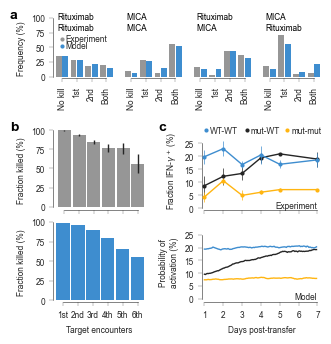

In [19]:
# FIGURE PROPERTIES

w       = SINGLE_COLUMN
hshrink = 1.3 * (3/4)
goldh   = w * hshrink
fig     = plt.figure(figsize=(w, goldh))

box_left   = 0.15
box_right  = 0.95
box_top    = 0.97
box_bottom = 0.10

dx = 0.17
x  = (box_right - box_left - 1*dx)/2.3

dy = dx / (hshrink * (box_top - box_bottom) / (box_right - box_left))
y  = (box_top - box_bottom - 2*dy)/3


# box_a = dict(left=box_left, right=box_right, top=box_top,          bottom=box_top-1*y)
# box_b = dict(left=box_left, right=0.55,      top=box_top-1*y-1*dy, bottom=box_top-2*y-1*dy)
# box_c = dict(left=box_left, right=box_right, top=box_top-2*y-2*dy, bottom=box_top-3*y-2*dy)

# gs_a  = gridspec.GridSpec(1, 4, wspace=0.10, hspace=0.10, **box_a)
# gs_b  = gridspec.GridSpec(1, 2, wspace=0.10, hspace=0.10, **box_b)
# gs_c  = gridspec.GridSpec(1, 1, wspace=0.10, hspace=0.10, **box_c)

box_a = dict(left=box_left,      right=box_right,  top=box_top,          bottom=box_top-1*y)
box_b = dict(left=box_left,      right=box_left+x, top=box_top-1*y-1*dy, bottom=box_top-3*y-2*dy)
box_c = dict(left=box_left+x+dx, right=box_right,  top=box_top-1*y-1*dy, bottom=box_top-3*y-2*dy)

gs_a  = gridspec.GridSpec(1, 4, wspace=0.15, hspace=0.15, **box_a)
gs_b  = gridspec.GridSpec(2, 1, wspace=0.15, hspace=0.15, **box_b)
gs_c  = gridspec.GridSpec(2, 1, wspace=0.15, hspace=0.15, **box_c)

# PANEL A: SRPAN ET AL

# update the mean and std
def training(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=0, signal_std=1):
    betac1 = (alpha-1)/(alpha-0.5)
    betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
    for nstep in range(int(np.round(num_encounter))):
        xs = signal_mean+signal_std*np.random.randn(n_cells)  # gauss(mean,std)
        ms_new = (kappa*ms_est+xs)/(kappa+1)
        betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
        ms_est = ms_new
        beta_est = betas_new
    return(ms_est, beta_est)

def killing(alpha, kappa, n_cells, ms_est, beta_est, mu_1, sigma_1, mu_2, sigma_2):
    betac1 = (alpha-1)/(alpha-0.5)
    betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
    res_rr = np.zeros((n_cells,2))
    xs = np.random.randn(n_cells) * sigma_1 + mu_1
    for i in range(n_cells):
        threshold = sp.stats.t.ppf(1-theta, 2*alpha, ms_est[i], np.sqrt((kappa+1)*beta_est[i]/kappa/alpha))
        if threshold < xs[i]:
            res_rr[i,0] = 1
    ms_new = (kappa*ms_est+xs)/(kappa+1)
    betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
    xs = np.random.randn(n_cells) * sigma_2 + mu_2
    for i in range(n_cells):
        threshold = sp.stats.t.ppf(1-theta, 2*alpha, ms_new[i], np.sqrt((kappa+1)*betas_new[i]/kappa/alpha))
        if threshold < xs[i]:
            res_rr[i,1] = 1
    # stat
    rr00=0
    rr10=0
    rr01=0
    rr11=0
    for i in range(n_cells):
        if res_rr[i,0]==0 and res_rr[i,1]==0:
            rr00+=1
        elif res_rr[i,0]==1 and res_rr[i,1]==0:
            rr10+=1
        elif res_rr[i,0]==0 and res_rr[i,1]==1:
            rr01+=1
        elif res_rr[i,0]==1 and res_rr[i,1]==1:
            rr11+=1
    rr = np.array([rr00,rr10,rr01,rr11])/n_cells*100
    return(rr)


# experiment

rr_e = np.array([0.345, 0.285, 0.18, 0.19])*100
mm_e = np.array([0.1, 0.285, 0.055, 0.56])*100
rm_e = np.array([0.16, 0.03, 0.44, 0.37])*100
mr_e = np.array([0.18, 0.71, 0.05, 0.06])*100

# model 

theta = 0.01
alpha = 21.5
kappa = 2*alpha
num_encounter = 50*alpha
n_cells = 10000

mu_r = 2.2
sigma_r = 1
mu_m = 3.2
sigma_m = 1

ms_est = np.zeros(n_cells)
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = training(ms_est, beta_est, alpha, kappa, num_encounter) 

rr_m = killing(alpha, kappa, n_cells, ms_est, beta_est, mu_r, sigma_r, mu_r, sigma_r)
rm_m = killing(alpha, kappa, n_cells, ms_est, beta_est, mu_r, sigma_r, mu_m, sigma_m)
mm_m = killing(alpha, kappa, n_cells, ms_est, beta_est, mu_m, sigma_m, mu_m, sigma_m)
mr_m = killing(alpha, kappa, n_cells, ms_est, beta_est, mu_m, sigma_m, mu_r, sigma_r)

# plotting

nps = 4
axs = [plt.subplot(gs_a[0, j]) for j in range(nps)]

colors  = [LCOLOR, COLOR_ONE]
values  = [[rr_e, mm_e, rm_e, mr_e], [rr_m, mm_m, rm_m, mr_m]]
xlabels = ['No kill', '1st', '2nd', 'Both']
plabels = ['Rituximab\nRituximab', 'MICA\nMICA', 'Rituximab\nMICA', 'MICA\nRituximab']


for j in range(nps):
    for i in range(2):
        
        txt_props = dict(family=FONTFAMILY, size=SIZELABEL, clip_on=False)
        bar_props = dict(lw=0, width=0.40, align='center', orientation='vertical')
        
        pprops = { 'xlim':        [-0.5, 3.5],
                   'xticks':      [0, 1, 2, 3],
                   'xticklabels': xlabels,
                   'ylim':        [0, 100],
                   'yticks':      [],
                   'colors':      [colors[i]],
                   'plotprops':   bar_props,
                   'axoffset':    0.1,
                   'theme':       'open',
                   'hide':        ['left'] }
        
        if i==0:
            axs[j].text(-0.30, 80, plabels[j], **txt_props)
        if j==0:
            pprops['yticks'] = [0, 25, 50, 75, 100]
            pprops['ylabel'] = 'Frequency (%)'
            pprops['hide'].remove('left')
            
        mp.plot(type='bar', ax=axs[j], x=[np.arange(nps)-0.222+0.444*i], y=[values[i][j]], **pprops)
        
        if i==1:
            axs[j].tick_params(axis='x', labelrotation=90)
            
        # legend

        if i==0 and j==0:
            legend_x  = 0.25
            legend_d  = -0.25
            legend_y  = 65
            legend_dy = 12
            plotprops = dict(mew=0, markersize=SMALLSIZEDOT/2, fmt='o', elinewidth=SIZELINE/2, 
                             capthick=0, capsize=0, clip_on=False)

            mp.error(ax=axs[j], x=[[legend_x + legend_d]], y=[[legend_y]], 
                     colors=[LCOLOR], plotprops=plotprops)
            axs[j].text(legend_x, legend_y, 'Experiment', ha='left', va='center', **DEF_LABELPROPS)
            mp.error(ax=axs[j], x=[[legend_x + legend_d]], y=[[legend_y - legend_dy]],
                     colors=[COLOR_ONE], plotprops=plotprops)
            axs[j].text(legend_x, legend_y - legend_dy, 'Model', ha='left', va='center', **DEF_LABELPROPS)


# PANEL B: PRAGER ET AL

def initial_parameters(alpha, N):
    # update m=300 steps, healthy signal N(0,1)
    n_updates = 300
    kappa = 2*alpha
    ms = np.zeros(N)
    betas = np.ones(N)*alpha
    for j in range(n_updates):
        xs = np.random.randn(N)
        ms_new = (xs+kappa*ms)/(kappa+1)
        betas_new = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
        ms = ms_new
        betas = betas_new
    return (ms, betas)

def serial_kill(alpha, mu_t, sigma_t):
    N = 1000 # number of cells
    kappa = 2*alpha
    m, beta = initial_parameters(alpha, N)
    p = np.zeros(6)
    for i_encounter in range(6):
        threshold = sp.stats.t.ppf(0.99, 2*alpha, m, np.sqrt((kappa+1)*beta/kappa/alpha))
        x_rand = np.random.normal(mu_t,sigma_t,N)
        k = x_rand>threshold
        pk = 0
        for j in range(N):
            if k[j]==True:
                pk += 1
        pk = pk/N
        p[i_encounter] = pk
        mnew = (kappa*m+x_rand)/(kappa+1)
        betanew = (alpha-1)/(alpha-0.5)*(beta+0.5*kappa/(kappa+1)*(m-x_rand)**2)
        m = mnew
        beta = betanew
    return(p)

# experiment

n = np.array([347, 250, 151, 77, 38, 16])
y_e = np.array([0.997, 0.936, 0.848, 0.766, 0.763, 0.563])*100
x_e = np.array([1, 2, 3, 4, 5, 6])
y_e_std = np.sqrt(y_e/100*(1-y_e/100))
y_e_bar = y_e_std*100/np.sqrt(n)

# model

alpha, mu, sigma = 25.25, 4.65, 1
y_m = serial_kill(alpha, mu, sigma)*100
x_m = np.array([1, 2, 3, 4, 5, 6])

# plotting

axs = [plt.subplot(gs_b[i, 0]) for i in range(2)]

bar_props = dict(lw=0, width=0.9, align='center', orientation='vertical')

xlabels = ['1st', '2nd', '3rd', '4th', '5th', '6th']
        
pprops = { 'xlim':        [0.5, 6.5],
           'xticks':      [1, 2, 3, 4, 5, 6],
           'xticklabels': xlabels,
           'ylim':        [0, 100],
           'yticks':      [0, 25, 50, 75, 100],
           'ylabel':      'Fraction killed (%)',
           'plotprops':   bar_props,
           'axoffset':    0.1,
           'theme':       'open' }

pprops['colors'] = [COLOR_ONE]
pprops['xlabel'] = 'Target encounters'
mp.plot(type='bar', ax=axs[1], x=[x_m], y=[y_m], **pprops)

pprops['colors'] = [LCOLOR]
pprops['xticklabels'] = ['', '', '', '', '', '']
del pprops['xlabel']
mp.plot(type='bar', ax=axs[0], x=[x_e], y=[y_e], yerr=[y_e_bar], **pprops)


# PANEL C: ELLIOTT ET AL

# update the mean and std
def update(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=0, signal_std=1):
    betac1 = (alpha-1)/(alpha-0.5)
    betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
    for nstep in range(int(np.round(num_encounter))):
        xs = signal_mean+signal_std*np.random.randn(n_cells)  # gauss(mean,std)
        ms_new = (kappa*ms_est+xs)/(kappa+1)
        betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
        ms_est = ms_new
        beta_est = betas_new
    return ms_est, beta_est

# calculate the probability of activation
def POA(alpha, kappa, ms_est, beta_est, u_target, std_target, signal_mean=0, signal_std=1):
    n_updates = 150
    n_cells = len(ms_est)
    theta = 0.01
    betac1 = (alpha-1)/(alpha-0.5)
    betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
    poa_mean = []
    for i in range(n_updates):
        threshold = []
        poa = []
        for i in range(n_cells):
            threshold.append(sp.stats.t.ppf(1-theta, 2*alpha, ms_est[i], np.sqrt((kappa+1)*beta_est[i]/kappa/alpha)))
            poa.append(1-sp.stats.norm.cdf(threshold[-1], loc=u_target, scale=std_target))
        poa_mean.append(np.mean(poa))
        # update
        xs = signal_mean+signal_std*np.random.randn(n_cells) 
        ms_new = (kappa*ms_est+xs)/(kappa+1)
        betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
        ms_est = ms_new
        beta_est = betas_new
    return poa_mean

# model

# WT blue line N(0,1), target N(0.9, 1.78)  
mu_a = 1.49
std_a = 1

mu_d = 0.59
std_d = 1

# constants
alpha = 20
kappa = 2*alpha

#initial encounters
num_encounter = 50*alpha
n_cells = 100

# WT -- WT
ms_est = np.zeros(n_cells)
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = update(ms_est, beta_est, alpha, kappa, num_encounter) 
model_wt_wt = POA(alpha, kappa, ms_est, beta_est, mu_a, std_a, signal_mean=0)

# mut -- mut
ms_est = np.ones(n_cells)*mu_d
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = update(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=mu_d) 
model_mut_mut = POA(alpha, kappa, ms_est, beta_est, mu_a, std_a, signal_mean=mu_d)

# mut -- WT
ms_est = np.ones(n_cells)*mu_d
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = update(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=mu_d) 
model_mut_wt = POA(alpha, kappa, ms_est, beta_est, mu_a, std_a, signal_mean=0)

# experiment

exp_wt_wt       = np.array([19.8, 22.9, 16.8, 20.5, 16.9, 18.6])/100
exp_wt_wt_err   = np.array([2.7, 2.9, 1.3, 3.3, 1.6, 2.8])/100
exp_mut_mut     = np.array([4.4, 10.6, 5, 6.2, 7.2, 7.2])/100
exp_mut_mut_err = np.array([2, 1.1, 1.9, 0.8, 0.7, 0.4])/100
exp_mut_wt      = np.array([8.7, 12.3, 13.4, 19.4, 20.9, 18.9])/100
exp_mut_wt_err  = np.array([3.6, 3.3, 2.6, 2.0, 0.3, 2.9])/100

# plotting

axs = [plt.subplot(gs_c[i, 0]) for i in range(2)]

pprops = { 'ylim':        [0, 0.30],
           'yticks':      [0, 0.05, 0.10, 0.15, 0.20, 0.25],
           'yticklabels': [0, 5, 10, 15, 20, 25],
           'colors':      [COLOR_ONE, COLOR_TWO, BKCOLOR],
           'axoffset':    0.1,
           'theme':       'open' }

err_props = DEF_ERRORPROPS.copy()
err_props['lw'] = SIZELINE
pprops['plotprops'] = err_props
pprops['xlim'] = [1, 7.2]
pprops['xticks'] = [1, 2, 3, 4, 5, 6, 7]
pprops['xticklabels'] = ['', '', '', '', '', '', '']
pprops['ylabel'] = r'Fraction IFN-$\gamma^+$ (%)'

x = np.array([1, 2, 3, 4, 5, 7])
mp.plot(type='error', ax=axs[0], x=[x, x, x], y=[exp_wt_wt, exp_mut_mut, exp_mut_wt], 
        yerr=[exp_wt_wt_err, exp_mut_mut_err, exp_mut_wt_err], **pprops)

line_props = DEF_LINEPROPS.copy()
pprops['plotprops'] = line_props
mp.line(ax=axs[0], x=[x, x, x], y=[exp_wt_wt, exp_mut_mut, exp_mut_wt], **pprops)

pprops['xlim'] = [20, 144]
pprops['xticks'] = [20, 40, 60, 80, 100, 120, 140]
pprops['xticklabels'] = [1, 2, 3, 4, 5, 6, 7]
pprops['xlabel'] = 'Days post-transfer'
pprops['ylabel'] = 'Probability of\nactivation (%)'
           
start = 20
x = np.array(range(start, 140))

mp.plot(type='line', ax=axs[1], x=[x, x, x], 
        y=[model_wt_wt[start:-10], model_mut_mut[start:-10], model_mut_wt[start:-10]], **pprops)

# legend

legend_x  = 1.3
legend_dx = 2.15
legend_d  = -0.20
legend_y  = 0.30
legend_dy = 0.05
plotprops = dict(mew=0, markersize=SMALLSIZEDOT/2, fmt='o', elinewidth=SIZELINE/2, 
                 capthick=0, capsize=0, clip_on=False)

mp.error(ax=axs[0], x=[[legend_x + legend_d]], y=[[legend_y]], colors=[COLOR_ONE], plotprops=plotprops)
axs[0].text(legend_x, legend_y, 'WT-WT', ha='left', va='center', **DEF_LABELPROPS)
mp.error(ax=axs[0], x=[[legend_x + legend_d + 1*legend_dx]], y=[[legend_y]], colors=[BKCOLOR], plotprops=plotprops)
axs[0].text(legend_x + 1*legend_dx, legend_y, 'mut-WT', ha='left', va='center', **DEF_LABELPROPS)
mp.error(ax=axs[0], x=[[legend_x + legend_d + 2*legend_dx]], y=[[legend_y]], colors=[COLOR_TWO], plotprops=plotprops)
axs[0].text(legend_x + 2*legend_dx, legend_y, 'mut-mut', ha='left', va='center', **DEF_LABELPROPS)

axs[0].text(  7, 0.01, 'Experiment', ha='right', va='center', **DEF_LABELPROPS)
axs[1].text(140, 0.01, 'Model', ha='right', va='center', **DEF_LABELPROPS)


# SUBLABELS

dx = 0.13
dy = 0
fig.text(box_a['left']-dx, box_a['top']-dy, string.ascii_uppercase[0].lower(), size=SUBLABEL_SIZE, weight='bold')
fig.text(box_b['left']-dx, box_b['top']-dy, string.ascii_uppercase[1].lower(), size=SUBLABEL_SIZE, weight='bold')
fig.text(box_c['left']-dx, box_c['top']-dy, string.ascii_uppercase[2].lower(), size=SUBLABEL_SIZE, weight='bold')

# SAVE FIGURE
            
plt.savefig('figures/fig4-fitting-experiment-alt.pdf', dpi=1000, facecolor=fig.get_facecolor(), 
            edgecolor=None, **FIGPROPS)
plt.show()
plt.close(fig)